# Credit risk scorecards using linear and logistic regression models
**Sections summary**
1. Create and clean 2 data subsets based on 'Duration'
2. Create train and validation sets for each subset
3. Select 4 features including 1 continuous and 1 non-binary categorical
4. Build scorecards using linear and logistic regression
5. Evaluation metrics

In [27]:
# Libraries

# Core
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

# Model
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

**DATA IMPORT**

In [28]:
# Import data

url = "https://raw.githubusercontent.com/edwatson36/regression-ml/main/data/raw/GermanCreditData.xlsx"
df = pd.read_excel(url)

In [29]:
# Check import has worked (shape should = 1000, 22)

print(df.shape)
df.head(1)

(1000, 22)


,qChecking,nDuration,qHistory,qPurpose,nAmount,qSavings,qEmployed,nInstallp,qMarital,qCoapp,...,nAge,qOther,qHousing,nExistcr,qJob,nDepends,qTelephone,qForeign,Bad,Good
0,1,6,4,3,1169,5,5,4,3,1,...,67,3,2,2,3,1,2,1,0,1


# Section 1

Step 1: Check and clean data - converted 'X' values in 'qPurpose' column to 10 ('other' category). No other issues found.

Step 2: Split data based on nDuration.



In [30]:
# Step 1: Check and clean data

# Check column types # all int64 except qPurpose=object
print("\nColumn Names and Data Types:")
print(df.dtypes)

# Find unique values in qPurpose
print(f"\nUnique values in qPurpose: {df['qPurpose'].unique()}")
print(f"Number of 'X' in qPurpose: {df['qPurpose'].eq('X').sum()}")

# Convert 'X' to 10 (='other')
df['qPurpose'] = df['qPurpose'].replace('X', 10).astype(int)
print(f"\nUnique values in qPurpose after conversion: {df['qPurpose'].unique()}") # check conversion
print(f"qPurpose column type: {df['qPurpose'].dtype}") # check column type

# Check for blanks # no nulls
print("\nColumns and the number of NaNs")
print(df.isnull().sum())

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")



Column Names and Data Types:
qChecking      int64
nDuration      int64
qHistory       int64
qPurpose      object
nAmount        int64
qSavings       int64
qEmployed      int64
nInstallp      int64
qMarital       int64
qCoapp         int64
nResident      int64
qProperty      int64
nAge           int64
qOther         int64
qHousing       int64
nExistcr       int64
qJob           int64
nDepends       int64
qTelephone     int64
qForeign       int64
Bad            int64
Good           int64
dtype: object

Unique values in qPurpose: [3 6 2 0 1 9 4 5 'X' 8]
Number of 'X' in qPurpose: 12

Unique values in qPurpose after conversion: [ 3  6  2  0  1  9  4  5 10  8]
qPurpose column type: int64

Columns and the number of NaNs
qChecking     0
nDuration     0
qHistory      0
qPurpose      0
nAmount       0
qSavings      0
qEmployed     0
nInstallp     0
qMarital      0
qCoapp        0
nResident     0
qProperty     0
nAge          0
qOther        0
qHousing      0
nExistcr      0
qJob          0
nDe

/tmp/ipython-input-3940667878.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['qPurpose'] = df['qPurpose'].replace('X', 10).astype(int)


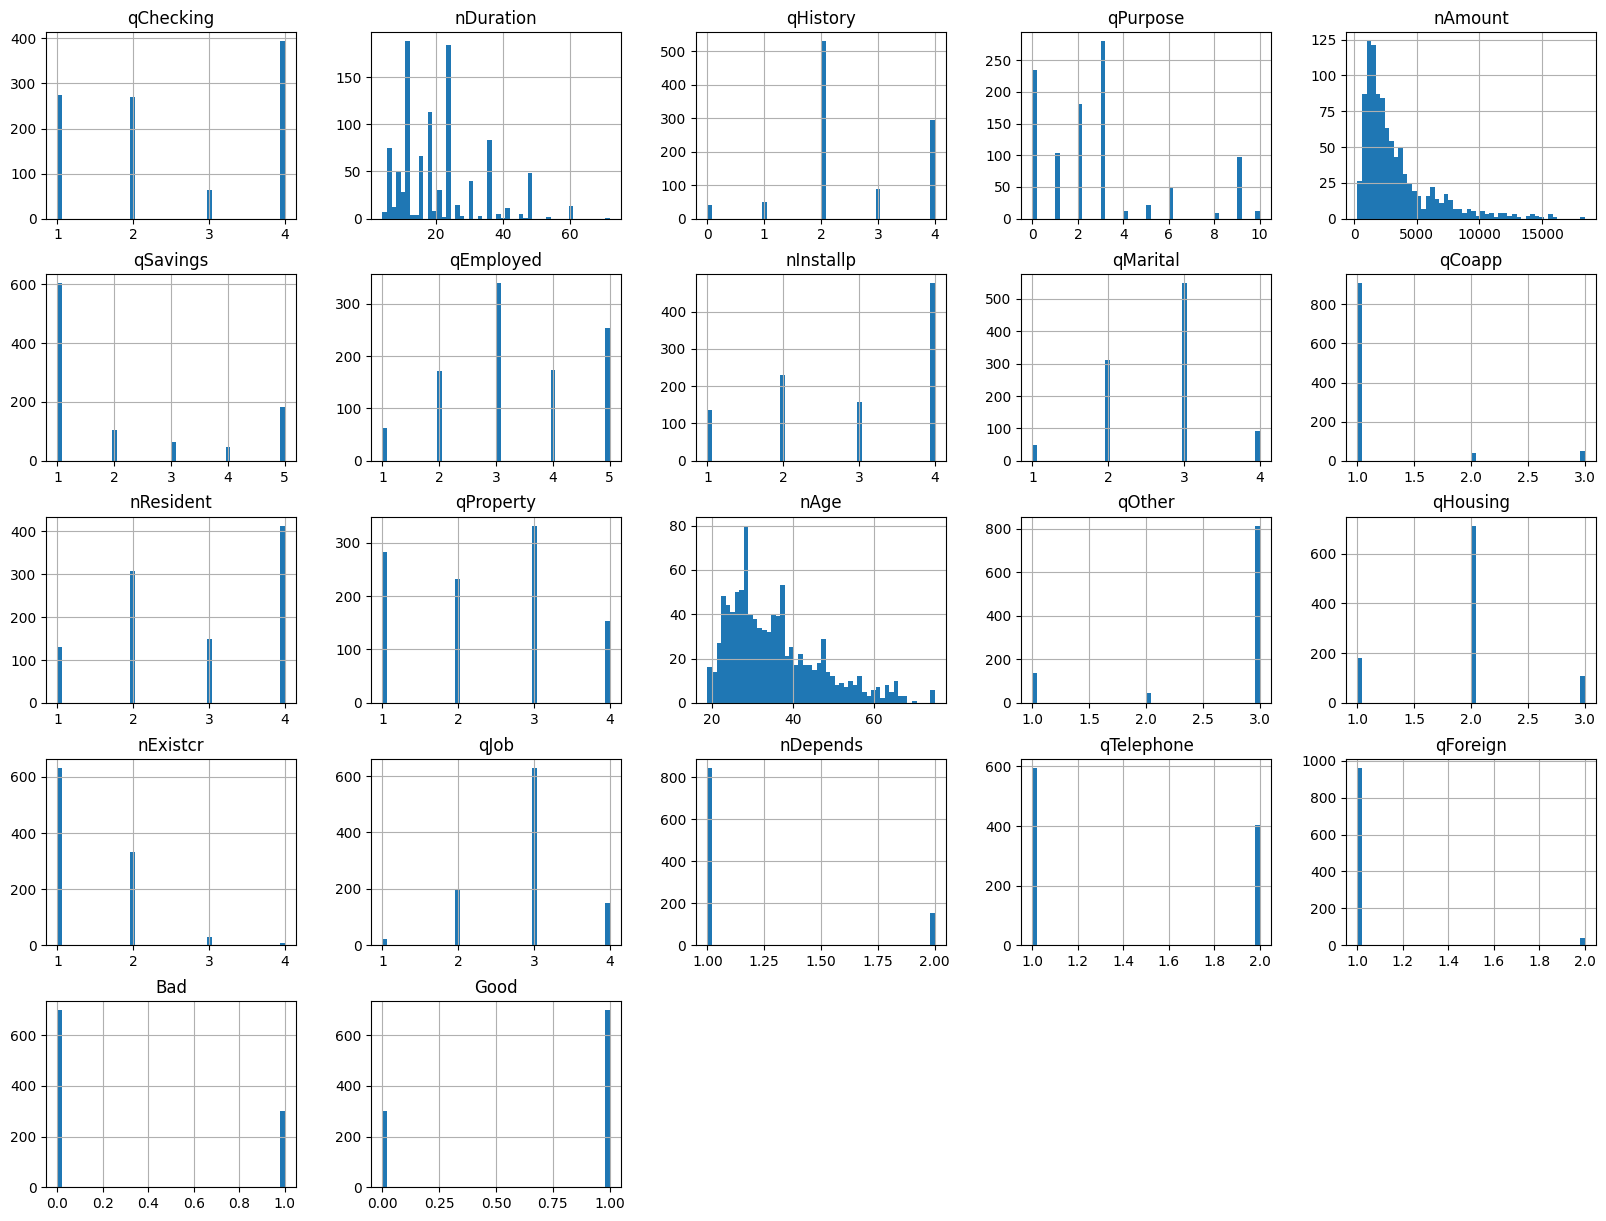

In [31]:
# Histogram of all columns - visual check for issues/imbalances
df.hist(bins=50, figsize=(20,15))
plt.show()

In [32]:
# Step 2: Split data

# Create lists of categorical and numerical variables for ease of future reference
categorical_cols = [col for col in df.columns if col.startswith('q')]
numerical_cols = [col for col in df.columns if col.startswith('n')]

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Categorical columns: ['qChecking', 'qHistory', 'qPurpose', 'qSavings', 'qEmployed', 'qMarital', 'qCoapp', 'qProperty', 'qOther', 'qHousing', 'qJob', 'qTelephone', 'qForeign']
Numerical columns: ['nDuration', 'nAmount', 'nInstallp', 'nResident', 'nAge', 'nExistcr', 'nDepends']


In [33]:
# Create 2 subsets based on 'nDuration'
df1 = df[df['nDuration'] <= 12].copy()
df2 = df[df['nDuration'] > 12].copy()

# List of DataFrames to iterate through
dfs = [df1, df2]

print(f"df1 shape: {df1.shape}")
print(f"df2 shape: {df2.shape}")

df1 shape: (359, 22)
df2 shape: (641, 22)


# Section 2

Step 1: Visual inspection of each subset using histograms to identify class imblances. Identifies the need to stratify based on target variable (more Goods than Bads). No intuition about particularly important predictive variables therefore no other stratification applied.

Step 2: Drop 'Bad' column, keep 'Good' column as target variable (y). This means that our models we be predicting 'Good' as 1, the positive class.

Step 3: Create train-validation splits. 20% chosen to maximise the amount of train data available whilst keeping a representative portion of data back for validation. Note that we have small amounts of data, particularly after creating the subsets based on duration.

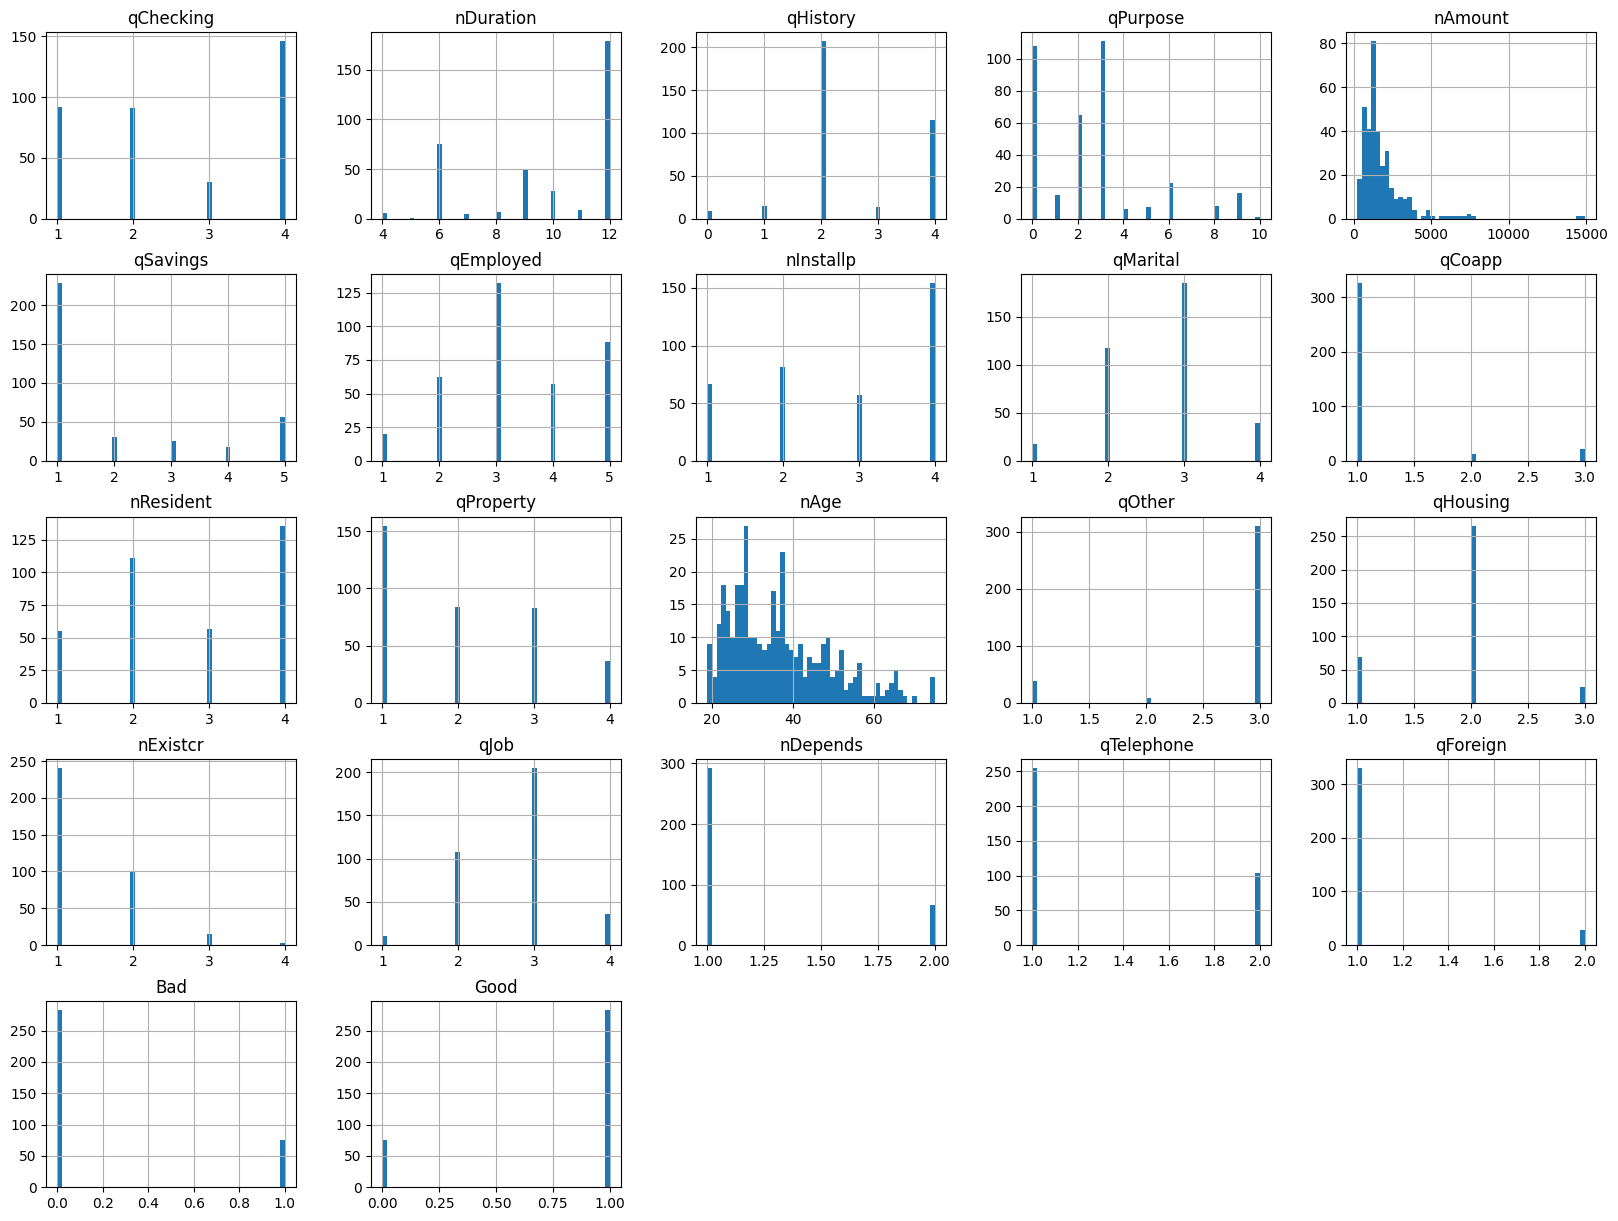

In [34]:
# Histogram of all columns - visual check for issues/imbalances
df1.hist(bins=50, figsize=(20,15))
plt.show()

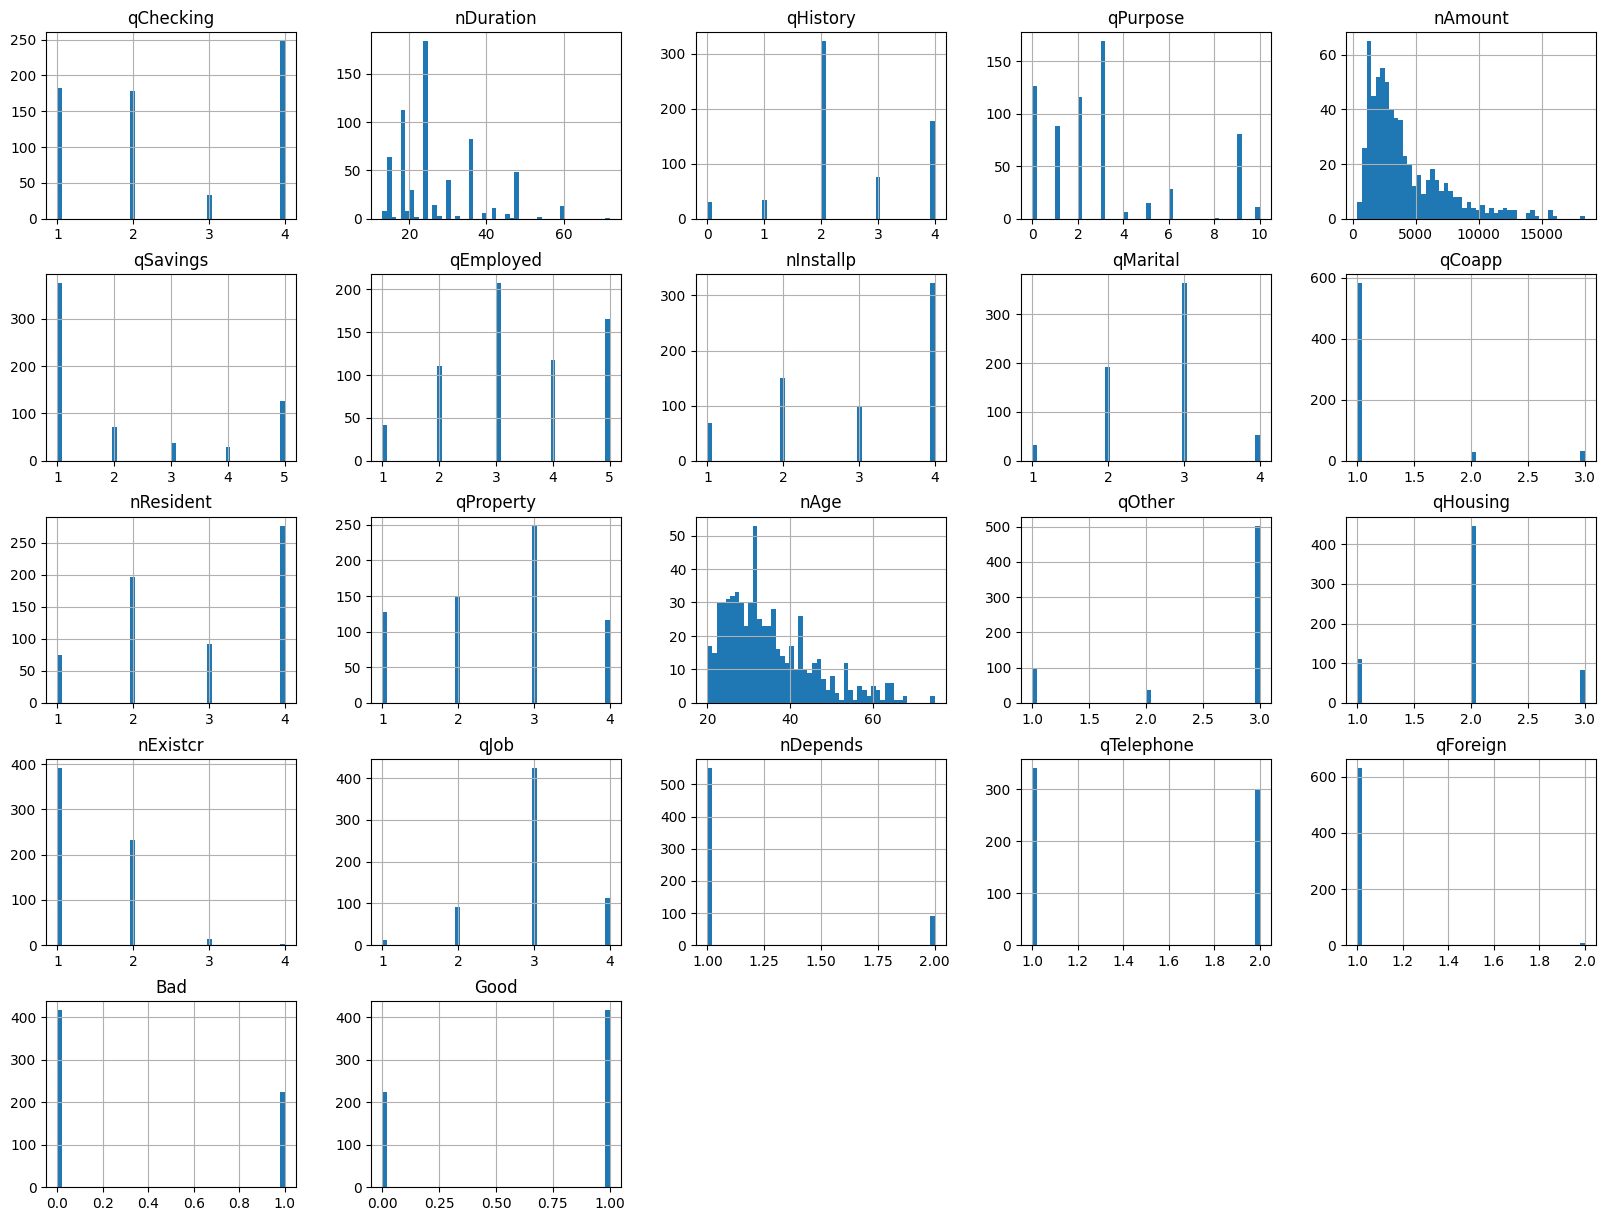

In [35]:
# Histogram of all columns - visual check for issues/imbalances
df2.hist(bins=50, figsize=(20,15))
plt.show()

In [36]:
# Select target variable column, drop redundant column

# Drop 'Bad' column
for d in dfs:
    d.drop(['Bad'], axis=1, inplace=True)

# Check
print(f"df1 shape: {df1.shape}")
print(f"df2 shape: {df2.shape}")

df1 shape: (359, 21)
df2 shape: (641, 21)


In [37]:
# Stratified train-test split

# Train-test split
# stratified on y because we have fewer bads than goods in both df1 and df2

# df1
x1 = df1.drop(columns=['Good'])
y1 = df1['Good']

x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.2, random_state=42, stratify=y1)

# Check same proportions of 0s/1s in train and test
proportion_df1 = pd.DataFrame({'y_train1': y_train1.value_counts(normalize=True), 'y_test1': y_test1.value_counts(normalize=True)})
print(f"Proportions for df1:\n{proportion_df1}\n")

# df2
x2 = df2.drop(columns=['Good'])
y2 = df2['Good']

x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=42, stratify=y2)

# Check same proportions of 0s/1s in train and test
proportion_df2 = pd.DataFrame({'y_train2': y_train2.value_counts(normalize=True), 'y_test2': y_test2.value_counts(normalize=True)})
print(f"Proportions for df2:\n{proportion_df2}\n")

# check
print(f"x_train1 shape: {x_train1.shape}")
print(f"y_train1 shape: {y_train1.shape}")
print(f"x_test1 shape: {x_test1.shape}")
print(f"y_test1 shape: {y_test1.shape}")
print(f"x_train2 shape: {x_train2.shape}")
print(f"y_train2 shape: {y_train2.shape}")
print(f"x_test2 shape: {x_test2.shape}")
print(f"y_test2 shape: {y_test2.shape}")

Proportions for df1:
      y_train1   y_test1
Good                    
1     0.787456  0.791667
0     0.212544  0.208333

Proportions for df2:
      y_train2   y_test2
Good                    
1     0.650391  0.651163
0     0.349609  0.348837

x_train1 shape: (287, 20)
y_train1 shape: (287,)
x_test1 shape: (72, 20)
y_test1 shape: (72,)
x_train2 shape: (512, 20)
y_train2 shape: (512,)
x_test2 shape: (129, 20)
y_test2 shape: (129,)


# Section 3

*Feature selection using LASSO regression*

Step 1:
* Shortlist features with highest absolute coefficients at the optimal LASSO regression penalty for binning and Information Value analysis
* Seeking features that have a high absolute coefficient and Information Value of >0.1



In [38]:
# Scale numerical variables

# Define MinMaxScaler for each subset
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()

# Scale only the numerical columns and replace in the original DataFrame
x_train1[numerical_cols] = scaler1.fit_transform(x_train1[numerical_cols])
x_train2[numerical_cols] = scaler2.fit_transform(x_train2[numerical_cols])

# Fit test sets to MinMaxScale
x_test1[numerical_cols] = scaler1.transform(x_test1[numerical_cols])
x_test2[numerical_cols] = scaler2.transform(x_test2[numerical_cols])


In [39]:
# Categorical variables

# One-hot encode categorical variables
x_train1_enc = pd.get_dummies(x_train1, columns=categorical_cols, drop_first=True)
x_train2_enc = pd.get_dummies(x_train2, columns=categorical_cols, drop_first=True)

x_test1_enc = pd.get_dummies(x_test1, columns=categorical_cols, drop_first=True)
x_test1_enc = x_test1.reindex(columns=x_train1_enc.columns, fill_value=0) # ensure train and test have the same columns to prevent errors when testing the fitted model
x_test2_enc = pd.get_dummies(x_test2, columns=categorical_cols, drop_first=True)
x_test2_enc = x_test2.reindex(columns=x_train2_enc.columns, fill_value=0) # ensure train and test have the same columns to prevent errors when testing the fitted model

# Create list of names of encoded categorical columns
categorical_cols_enc1 = [col for col in x_train1_enc.columns if col.startswith('q')]
print(f"Categorical columns x_train1: {categorical_cols_enc1}")
categorical_cols_enc1_ts = [col for col in x_test1_enc.columns if col.startswith('q')]
print(f"Categorical columns x_test1: {categorical_cols_enc1_ts}")
categorical_cols_enc2 = [col for col in x_train2_enc.columns if col.startswith('q')]
print(f"Categorical columns x_train2: {categorical_cols_enc2}")
categorical_cols_enc2_ts = [col for col in x_test2_enc.columns if col.startswith('q')]
print(f"Categorical columns x_test2: {categorical_cols_enc2_ts}")

Categorical columns x_train1: ['qChecking_2', 'qChecking_3', 'qChecking_4', 'qHistory_1', 'qHistory_2', 'qHistory_3', 'qHistory_4', 'qPurpose_1', 'qPurpose_2', 'qPurpose_3', 'qPurpose_4', 'qPurpose_5', 'qPurpose_6', 'qPurpose_8', 'qPurpose_9', 'qPurpose_10', 'qSavings_2', 'qSavings_3', 'qSavings_4', 'qSavings_5', 'qEmployed_2', 'qEmployed_3', 'qEmployed_4', 'qEmployed_5', 'qMarital_2', 'qMarital_3', 'qMarital_4', 'qCoapp_2', 'qCoapp_3', 'qProperty_2', 'qProperty_3', 'qProperty_4', 'qOther_2', 'qOther_3', 'qHousing_2', 'qHousing_3', 'qJob_2', 'qJob_3', 'qJob_4', 'qTelephone_2', 'qForeign_2']
Categorical columns x_test1: ['qChecking_2', 'qChecking_3', 'qChecking_4', 'qHistory_1', 'qHistory_2', 'qHistory_3', 'qHistory_4', 'qPurpose_1', 'qPurpose_2', 'qPurpose_3', 'qPurpose_4', 'qPurpose_5', 'qPurpose_6', 'qPurpose_8', 'qPurpose_9', 'qPurpose_10', 'qSavings_2', 'qSavings_3', 'qSavings_4', 'qSavings_5', 'qEmployed_2', 'qEmployed_3', 'qEmployed_4', 'qEmployed_5', 'qMarital_2', 'qMarital_3', 

In [40]:
# Use LASSO regression to determine which variables are useful

L1 = 0.1

# df1
reg = LassoCV()
reg.fit(x_train1_enc, y_train1)
coefs1 = pd.DataFrame({'feature': x_train1_enc.columns, 'coef1': reg.coef_})

# df2
reg.fit(x_train2_enc, y_train2)
coefs2 = pd.DataFrame({'feature': x_train2_enc.columns, 'coef2': reg.coef_})

# Merge coefficient results into one df
coef_df = pd.merge(coefs1, coefs2, on='feature')

# Sort
coef_df.sort_values(by=['coef1', 'coef2'], ascending=False, inplace=True)

In [41]:
# Plot coefficients at optimal penalty
fig = go.Figure()

# Add coef1
fig.add_trace(go.Bar(x=coef_df['feature'],y=coef_df['coef1'], name='Coef 1',marker_color='blue'))

# Add coef2
fig.add_trace(go.Bar(x=coef_df['feature'],y=coef_df['coef2'],name='Coef 2',marker_color='orange'))

# Update layout
fig.update_layout(
    title='Comparison of Coefficients',
    xaxis_title='Feature', xaxis=dict(tickangle=45, tickmode='array'),
    yaxis_title='Coefficient Value',
    barmode='group', template='plotly_white', width=1200, height=500
)

fig.show()

*Shortlist of variables for binning using coefficient threshold of >=abs(0.1)*

* Numerical variables:
    * x1 - Age, Duration
    * x2 - Duration, Installp
* Categorical variables:
    * x1 - Checking_4, Coapp_3, Property_4
    * x2 - Checking_4, Checking_3, Purpose_1, Coapp_3

* Best 4 variables (in order):
    * x1 - qChecking, qProperty, nDuration, qCoapp
    * x2 - qChecking, nDuration, qPurpose, qCoapp



*Binning numerical variables*

In [42]:
# Numerical variables binning

# Histogram of each shortlisted variable to identify potential bin thresholds

# Reverse MinMax Scaling for interpretability of bin thresholds
x_train1_fs = pd.DataFrame(scaler1.inverse_transform(x_train1[numerical_cols]), columns=x_train1[numerical_cols].columns, index=x_train1.index)
x_train2_fs = pd.DataFrame(scaler2.inverse_transform(x_train2[numerical_cols]), columns=x_train2[numerical_cols].columns, index=x_train2.index)

# Split data into Good and Bad for x_train1
good_credit1 = x_train1_fs[y_train1 == 1]
bad_credit1 = x_train1_fs[y_train1 == 0]

# Split data into Good and Bad for x_train2
good_credit2 = x_train2_fs[y_train2 == 1]
bad_credit2 = x_train2_fs[y_train2 == 0]

# Add goods for % calc
x_train1_fs['Good'] = y_train1.values
x_train2_fs['Good'] = y_train2.values

# Plot histograms
plt.figure(figsize=(15, 10))

# Create 3x2 subplots
fig = make_subplots(rows=3, cols=2, subplot_titles=[
    'nDuration Distribution (x_train1)',
    'nAge Distribution (x_train1)',
    'nDuration Distribution (x_train2)',
    'nInstallp Distribution (x_train2)',
    'nAmount Distribution (xtrain_2)',
    'nInstallp Distribution (x_train1)'
])

# Plot 1: nDuration (x_train1)
fig.add_trace(go.Histogram(x=good_credit1['nDuration'], name='Good Credit', marker_color='blue', opacity=0.5, xbins=dict(start=0, end=good_credit1['nDuration'].max()+1, size=1)), row=1, col=1)
fig.add_trace(go.Histogram(x=bad_credit1['nDuration'], name='Bad Credit', marker_color='red', opacity=0.5, xbins=dict(start=0, end=bad_credit1['nDuration'].max()+1, size=1)), row=1, col=1)
# Group by nDuration and calculate % of good applicants
dur1_good_pct = x_train1_fs.groupby('nDuration')['Good'].mean() * 100
fig.add_trace(go.Scatter(x=dur1_good_pct.index,y=dur1_good_pct.values,mode='lines+markers',name='% of Good Applicants', line=dict(color='blue'), marker=dict(size=6, color='blue')), row=1, col=1)

# Plot 2: nAge (x_train1)
fig.add_trace(go.Histogram(x=good_credit1['nAge'], name='Good Credit', marker_color='blue', opacity=0.5, xbins=dict(start=18, end=good_credit1['nAge'].max()+1, size=5)), row=1, col=2)
fig.add_trace(go.Histogram(x=bad_credit1['nAge'], name='Bad Credit', marker_color='red', opacity=0.5, xbins=dict(start=18, end=bad_credit1['nAge'].max()+1, size=5)), row=1, col=2)
# Group by nAge and calculate % of good applicants
age_good_pct = x_train1_fs.groupby('nAge')['Good'].mean() * 100
fig.add_trace(go.Scatter(x=age_good_pct.index,y=age_good_pct.values,mode='lines+markers',name='% of Good Applicants', line=dict(color='blue'), marker=dict(size=6, color='blue')), row=1, col=2)

# Plot 3: nDuration (x_train2)
fig.add_trace(go.Histogram(x=good_credit2['nDuration'], name='Good Credit', marker_color='blue', opacity=0.5, xbins=dict(start=10, end=good_credit2['nDuration'].max()+1, size=1)), row=2, col=1)
fig.add_trace(go.Histogram(x=bad_credit2['nDuration'], name='Bad Credit', marker_color='red', opacity=0.5, xbins=dict(start=10, end=bad_credit2['nDuration'].max()+1, size=1)), row=2, col=1)
# Group by nDuration and calculate % of good applicants
dur2_good_pct = x_train2_fs.groupby('nDuration')['Good'].mean() * 100
fig.add_trace(go.Scatter(x=dur2_good_pct.index,y=dur2_good_pct.values,mode='lines+markers',name='% of Good Applicants', line=dict(color='blue'), marker=dict(size=6, color='blue')), row=2, col=1)

# Plot 4: nInstallp (x_train2)
fig.add_trace(go.Histogram(x=good_credit2['nInstallp'], name='Good Credit', marker_color='blue', opacity=0.5, xbins=dict(start=0, end=good_credit2['nInstallp'].max()+1, size=1)), row=2, col=2)
fig.add_trace(go.Histogram(x=bad_credit2['nInstallp'], name='Bad Credit', marker_color='red', opacity=0.5, xbins=dict(start=0, end=bad_credit2['nInstallp'].max()+1, size=1)), row=2, col=2)
# Group by nInstallp and calculate % of good applicants
inst_good_pct = x_train2_fs.groupby('nInstallp')['Good'].mean() * 100
fig.add_trace(go.Scatter(x=inst_good_pct.index,y=inst_good_pct.values,mode='lines+markers',name='% of Good Applicants', line=dict(color='blue'), marker=dict(size=6, color='blue')), row=2, col=2)

# Plot 5: nAmount (x_train2)
fig.add_trace(go.Histogram(x=good_credit2['nAmount'], name='Good Credit', marker_color='blue', opacity=0.5, xbins=dict(start=0, end=good_credit2['nAmount'].max()+1, size=2500)), row=3, col=1)
fig.add_trace(go.Histogram(x=bad_credit2['nAmount'], name='Bad Credit', marker_color='red', opacity=0.5, xbins=dict(start=0, end=bad_credit2['nAmount'].max()+1, size=2500)), row=3, col=1)
# Group by nInstallp and calculate % of good applicants
#inst_good_pct = x_train2_fs.groupby('nAmount')['Good'].mean() * 100
#fig.add_trace(go.Scatter(x=inst_good_pct.index,y=inst_good_pct.values,mode='lines+markers',name='% of Good Applicants', line=dict(color='blue'), marker=dict(size=6, color='blue')), row=3, col=1)

# Plot 5: nInstallp (x_train1)
fig.add_trace(go.Histogram(x=good_credit1['nInstallp'], name='Good Credit', marker_color='blue', opacity=0.5, xbins=dict(start=0, end=good_credit1['nInstallp'].max()+1, size=1)), row=3, col=2)
fig.add_trace(go.Histogram(x=bad_credit1['nInstallp'], name='Bad Credit', marker_color='red', opacity=0.5, xbins=dict(start=0, end=bad_credit1['nInstallp'].max()+1, size=1)), row=3, col=2)

# Group by nInstallp and calculate % of good applicants
inst_good_pct = x_train1_fs.groupby('nInstallp')['Good'].mean() * 100
fig.add_trace(go.Scatter(x=inst_good_pct.index, y=inst_good_pct.values, mode='lines+markers', name='% of Good Applicants', line=dict(color='blue'), marker=dict(size=6, color='blue')), row=3, col=2)



# Update layout
fig.update_layout(
    title='Numerical variables - good/bad distributions',
    barmode='overlay',
    width=900,
    height=700,
    template='plotly_white',
    showlegend=True
)

fig.show()

# x1 Duration - 5 bins 4-5, 6-7, 8-9, 10-11, 12; 3 bins 4-7, 8-11, 12
# x1 Age - decades - 5 bins 19-29, 30-39, 40-49, 50-59, 60+ ;
# x2 Duration - longer is higher risk - 4 c12 month bins 13-24, 25-36, 37-48, 49+ or 13-23, 24-35, 36-47, 48+
# x2 Installp - 1+2 vs. 3+4, 1+2+3 vs. 4
# x2 nAmount - 0-5k, 5-10k, >10k


<Figure size 1500x1000 with 0 Axes>

In [43]:
# Work out the best binning option for each variable and calculate the WOE and IV of each bin

In [44]:
# 3 binning options for x_train1['nDuration']

# Decision - x1_dur_o2 - 3 buckets - good IV of 0.3 and 5 buckets IV of 0.843 is possibly over-predicting

ep = 1e-6

#################################
# x1_dur_o1
#################################
bins = [0, 11, 12]  # Define the bin edges
labels = ['4-11 mnth', '12 mnth']  # Labels for the bins

# Bin the 'nDuration' values
x_train1_fs['nDuration_bin'] = pd.cut(x_train1_fs['nDuration'], bins=bins, labels=labels, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x1_dur_o1 = pd.crosstab(x_train1_fs['nDuration_bin'], x_train1_fs['Good'], dropna=False).reset_index()
x1_dur_o1.columns = ['Bin', 'Bads', 'Goods']
x1_dur_o1 = x1_dur_o1[['Bin','Goods','Bads', ]] # re-order columns

# Calculate G_i/G and B_i/B
x1_dur_o1['Good%'] = x1_dur_o1['Goods'] / x1_dur_o1['Goods'].sum()
x1_dur_o1['Bad%'] = x1_dur_o1['Bads'] / x1_dur_o1['Bads'].sum()

# Calculate WOE for each row
x1_dur_o1['WOE'] = np.log(x1_dur_o1['Good%'] / x1_dur_o1['Bad%'])

# Calculate IV for each row
x1_dur_o1['IV'] = (x1_dur_o1['Good%'] - x1_dur_o1['Bad%']) * x1_dur_o1['WOE']

# Calculate total IV
total_IV = x1_dur_o1['IV'].sum()

# Print results
print(x1_dur_o1)
print(f"Total IV: {total_IV}")

#################################
# x1_dur_o2
#################################
bins_x1dur2 = [0, 7, 11, 12]  # Define the bin edges
labels_x1dur2 = ['4-7','8-11', '12']  # Labels for the bins

# Bin the 'nDuration' values
x_train1_fs['nDuration_bin'] = pd.cut(x_train1_fs['nDuration'], bins=bins_x1dur2, labels=labels_x1dur2, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x1_dur_o2 = pd.crosstab(x_train1_fs['nDuration_bin'], x_train1_fs['Good'], dropna=False).reset_index()
x1_dur_o2.columns = ['Bin', 'Bads', 'Goods']
x1_dur_o2 = x1_dur_o2[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x1_dur_o2['Good%'] = x1_dur_o2['Goods'] / x1_dur_o2['Goods'].sum()
x1_dur_o2['Bad%'] = x1_dur_o2['Bads'] / x1_dur_o2['Bads'].sum()

# Calculate WOE for each row
x1_dur_o2['WOE'] = np.log(x1_dur_o2['Good%'] / x1_dur_o2['Bad%'])

# Calculate IV for each row
x1_dur_o2['IV'] = (x1_dur_o2['Good%'] - x1_dur_o2['Bad%']) * x1_dur_o2['WOE']

# Calculate total IV
total_IV = x1_dur_o2['IV'].sum()

# Print results
print(x1_dur_o2)
print(f"Total IV: {total_IV}")

#################################
# x1_dur_o3
#################################
bins = [0, 5, 7, 9, 11, 12]  # Define the bin edges
labels = ['4-5 mnth','6-7 mnth', '8-9 mnth', '10-11 mnth', '12 mnth']  # Labels for the bins

# Bin the 'nDuration' values
x_train1_fs['nDuration_bin'] = pd.cut(x_train1_fs['nDuration'], bins=bins, labels=labels, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x1_dur_o3 = pd.crosstab(x_train1_fs['nDuration_bin'], x_train1_fs['Good'], dropna=False).reset_index()
x1_dur_o3.columns = ['Bin', 'Bads', 'Goods']
x1_dur_o3 = x1_dur_o3[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x1_dur_o3['Good%'] = (x1_dur_o3['Goods']+ep) / x1_dur_o3['Goods'].sum()
x1_dur_o3['Bad%'] = (x1_dur_o3['Bads']+ep) / x1_dur_o3['Bads'].sum()

# Calculate WOE for each row
x1_dur_o3['WOE'] = np.log(x1_dur_o3['Good%'] / x1_dur_o3['Bad%'])

# Calculate IV for each row
x1_dur_o3['IV'] = (x1_dur_o3['Good%'] - x1_dur_o3['Bad%']) * x1_dur_o3['WOE']

# Calculate total IV
total_IV = x1_dur_o3['IV'].sum()

# Print results
print(x1_dur_o3)
print(f"Total IV: {total_IV}")


         Bin  Goods  Bads     Good%      Bad%       WOE        IV
0  4-11 mnth    125    20  0.553097  0.327869  0.522920  0.117777
1    12 mnth    101    41  0.446903  0.672131 -0.408113  0.091919
Total IV: 0.2096951622851638
    Bin  Goods  Bads     Good%      Bad%       WOE        IV
0   4-7     65     6  0.287611  0.098361  1.072967  0.203059
1  8-11     60    14  0.265487  0.229508  0.145626  0.005239
2    12    101    41  0.446903  0.672131 -0.408113  0.091919
Total IV: 0.3002169201827565
          Bin  Goods  Bads     Good%          Bad%        WOE        IV
0    4-5 mnth      7     0  0.030973  1.639344e-08  14.451760  0.447621
1    6-7 mnth     58     6  0.256637  9.836067e-02   0.959022  0.151791
2    8-9 mnth     31    12  0.137168  1.967213e-01  -0.360581  0.021474
3  10-11 mnth     29     2  0.128319  3.278690e-02   1.364487  0.130352
4     12 mnth    101    41  0.446903  6.721312e-01  -0.408113  0.091919
Total IV: 0.843155476205725


In [45]:
# binning of x_train1['nAge']

# Decision - only include if categorical variables have less good IVs than 0.21

bins = [0, 30, 40, 50, 60, np.inf]
labels = ['19-29', '30-39', '40-49', '50-59', '60+']

# Bin the 'nAge' values
x_train1_fs['nAge_bin'] = pd.cut(x_train1_fs['nAge'], bins=bins, labels=labels, right=False)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x1_age = pd.crosstab(x_train1_fs['nAge_bin'], x_train1_fs['Good'], dropna=False).reset_index()
x1_age.columns = ['Bin', 'Bads', 'Goods']
x1_age = x1_age[['Bin', 'Goods', 'Bads']]  # re-order columns

# Calculate G_i/G and B_i/B
x1_age['Good%'] = (x1_age['Goods'] + ep) / (x1_age['Goods'].sum() + ep)
x1_age['Bad%'] = (x1_age['Bads'] + ep) / (x1_age['Bads'].sum() + ep)

# Calculate WOE for each row
x1_age['WOE'] = np.log(x1_age['Good%'] / x1_age['Bad%'])

# Calculate IV for each row
x1_age['IV'] = (x1_age['Good%'] - x1_age['Bad%']) * x1_age['WOE']

# Calculate total IV
total_IV = x1_age['IV'].sum()

# Print results
print(x1_age)
print(f"Total IV: {total_IV}")


     Bin  Goods  Bads     Good%      Bad%       WOE        IV
0  19-29     72    33  0.318584  0.540984 -0.529503  0.117761
1  30-39     71    14  0.314159  0.229508  0.313961  0.026577
2  40-49     44     7  0.194690  0.114754  0.528618  0.042256
3  50-59     24     4  0.106195  0.065574  0.482098  0.019583
4    60+     15     3  0.066372  0.049180  0.299777  0.005154
Total IV: 0.21133083676284922


In [46]:
# Interestingly, IV of Installp for subset 1 is much stronger despite LASSO regression results - 0.22. This is a better IV than age but with fewer buckets.

# Decision - potentially use option 3 of this feature if other categorical variables have lower IVs.

#################################
# x1_installp_o1
#################################
# Option 1: Bin edges [0, 2, np.inf]
bins_o1 = [0, 2, np.inf]
labels_o1 = ['0-2 Installp', '3+ Installp']

# Bin the 'nInstallp' values
x_train1_fs['nInstallp_bin'] = pd.cut(x_train1_fs['nInstallp'], bins=bins_o1, labels=labels_o1, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x1_installp_o1 = pd.crosstab(x_train1_fs['nInstallp_bin'], x_train1_fs['Good'], dropna=False).reset_index()
x1_installp_o1.columns = ['Bin', 'Bads', 'Goods']
x1_installp_o1 = x1_installp_o1[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x1_installp_o1['Good%'] = x1_installp_o1['Goods'] / x1_installp_o1['Goods'].sum()
x1_installp_o1['Bad%'] = x1_installp_o1['Bads'] / x1_installp_o1['Bads'].sum()

# Calculate WOE for each row
x1_installp_o1['WOE'] = np.log(x1_installp_o1['Good%'] / x1_installp_o1['Bad%'])

# Calculate IV for each row
x1_installp_o1['IV'] = (x1_installp_o1['Good%'] - x1_installp_o1['Bad%']) * x1_installp_o1['WOE']

# Calculate total IV
total_IV_o1 = x1_installp_o1['IV'].sum()

# Print results
print(x1_installp_o1)
print(f"Total IV for x1_installp_o1: {total_IV_o1}")


#################################
# x1_installp_o2
#################################
# Option 2: Bin edges [0, 3, np.inf]
bins_o2 = [0, 3, np.inf]
labels_o2 = ['0-3 Installp', '4+ Installp']

# Bin the 'nInstallp' values
x_train1_fs['nInstallp_bin'] = pd.cut(x_train1_fs['nInstallp'], bins=bins_o2, labels=labels_o2, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x1_installp_o2 = pd.crosstab(x_train1_fs['nInstallp_bin'], x_train1_fs['Good'], dropna=False).reset_index()
x1_installp_o2.columns = ['Bin', 'Bads', 'Goods']
x1_installp_o2 = x1_installp_o2[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x1_installp_o2['Good%'] = x1_installp_o2['Goods'] / x1_installp_o2['Goods'].sum()
x1_installp_o2['Bad%'] = x1_installp_o2['Bads'] / x1_installp_o2['Bads'].sum()

# Calculate WOE for each row
x1_installp_o2['WOE'] = np.log(x1_installp_o2['Good%'] / x1_installp_o2['Bad%'])

# Calculate IV for each row
x1_installp_o2['IV'] = (x1_installp_o2['Good%'] - x1_installp_o2['Bad%']) * x1_installp_o2['WOE']

# Calculate total IV
total_IV_o2 = x1_installp_o2['IV'].sum()

# Print results
print(x1_installp_o2)
print(f"Total IV for x1_installp_o2: {total_IV_o2}")


#################################
# x1_installp_o3
#################################
# Option 3: Bin edges [0, 2, 3, np.inf]
bins_o3 = [0, 2, 3, np.inf]
labels_o3 = ['0-2', '3', '4+']

# Bin the 'nInstallp' values
x_train1_fs['nInstallp_bin'] = pd.cut(x_train1_fs['nInstallp'], bins=bins_o3, labels=labels_o3, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x1_installp_o3 = pd.crosstab(x_train1_fs['nInstallp_bin'], x_train1_fs['Good'], dropna=False).reset_index()
x1_installp_o3.columns = ['Bin', 'Bads', 'Goods']
x1_installp_o3 = x1_installp_o3[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x1_installp_o3['Good%'] = x1_installp_o3['Goods'] / x1_installp_o3['Goods'].sum()
x1_installp_o3['Bad%'] = x1_installp_o3['Bads'] / x1_installp_o3['Bads'].sum()

# Calculate WOE for each row
x1_installp_o3['WOE'] = np.log(x1_installp_o3['Good%'] / x1_installp_o3['Bad%'])

# Calculate IV for each row
x1_installp_o3['IV'] = (x1_installp_o3['Good%'] - x1_installp_o3['Bad%']) * x1_installp_o3['WOE']

# Calculate total IV
total_IV_o3 = x1_installp_o3['IV'].sum()

# Print results
print(x1_installp_o3)
print(f"Total IV for x1_installp_o3: {total_IV_o3}")


            Bin  Goods  Bads     Good%      Bad%       WOE        IV
0  0-2 Installp    107    16  0.473451  0.262295  0.590579  0.124704
1   3+ Installp    119    45  0.526549  0.737705 -0.337200  0.071202
Total IV for x1_installp_o1: 0.1959063532534705
            Bin  Goods  Bads     Good%     Bad%       WOE        IV
0  0-3 Installp    144    26  0.637168  0.42623  0.402056  0.084809
1   4+ Installp     82    35  0.362832  0.57377 -0.458290  0.096671
Total IV for x1_installp_o2: 0.18148012000343153
   Bin  Goods  Bads     Good%      Bad%       WOE            IV
0  0-2    107    16  0.473451  0.262295  0.590579  1.247044e-01
1    3     37    10  0.163717  0.163934 -0.001328  2.890575e-07
2   4+     82    35  0.362832  0.573770 -0.458290  9.667106e-02
Total IV for x1_installp_o3: 0.2213757841278414


In [47]:
# binning of x_train2['nDuration']

# 2 binning options considered

# Decision - option 2 - better IV at 0.12

#################################
# x2_dur_o1
#################################
bins = [0, 24, 36, 48, np.inf]
labels = ['13-24 mnth', '25-36 mnth', '37-48 mnth', '49+ mnth']

# Bin the 'nDuration' values
x_train2_fs['nDuration_bin'] = pd.cut(x_train2_fs['nDuration'], bins=bins, labels=labels, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x2_dur_o1 = pd.crosstab(x_train2_fs['nDuration_bin'], x_train2_fs['Good'], dropna=False).reset_index()
x2_dur_o1.columns = ['Bin', 'Bads', 'Goods']
x2_dur_o1 = x2_dur_o1[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x2_dur_o1['Good%'] = x2_dur_o1['Goods'] / x2_dur_o1['Goods'].sum()
x2_dur_o1['Bad%'] = x2_dur_o1['Bads'] / x2_dur_o1['Bads'].sum()

# Calculate WOE for each row
x2_dur_o1['WOE'] = np.log(x2_dur_o1['Good%'] / x2_dur_o1['Bad%'])

# Calculate IV for each row
x2_dur_o1['IV'] = (x2_dur_o1['Good%'] - x2_dur_o1['Bad%']) * x2_dur_o1['WOE']

# Calculate total IV
total_IV_o1 = x2_dur_o1['IV'].sum()

# Print results
print(x2_dur_o1)
print(f"Total IV for x2_dur_o1: {total_IV_o1}")

#################################
# x2_dur_o2
#################################
bins_dur2 = [0, 23, 35, 47, np.inf]
labels_dur2 = ['13-23', '24-35', '36-47', '48+']

# Bin the 'nDuration' values
x_train2_fs['nDuration_bin'] = pd.cut(x_train2_fs['nDuration'], bins=bins_dur2, labels=labels_dur2, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x2_dur_o2 = pd.crosstab(x_train2_fs['nDuration_bin'], x_train2_fs['Good'], dropna=False).reset_index()
x2_dur_o2.columns = ['Bin', 'Bads', 'Goods']
x2_dur_o2 = x2_dur_o2[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x2_dur_o2['Good%'] = x2_dur_o2['Goods'] / x2_dur_o2['Goods'].sum()
x2_dur_o2['Bad%'] = x2_dur_o2['Bads'] / x2_dur_o2['Bads'].sum()

# Calculate WOE for each row
x2_dur_o2['WOE'] = np.log(x2_dur_o2['Good%'] / x2_dur_o2['Bad%'])

# Calculate IV for each row
x2_dur_o2['IV'] = (x2_dur_o2['Good%'] - x2_dur_o2['Bad%']) * x2_dur_o2['WOE']

# Calculate total IV
total_IV_o2 = x2_dur_o2['IV'].sum()

# Print results
print(x2_dur_o2)
print(f"Total IV for x2_dur_o2: {total_IV_o2}")


          Bin  Goods  Bads     Good%      Bad%       WOE        IV
0  13-24 mnth    229    98  0.687688  0.547486  0.227998  0.031966
1  25-36 mnth     69    45  0.207207  0.251397 -0.193313  0.008542
2  37-48 mnth     27    29  0.081081  0.162011 -0.692216  0.056021
3    49+ mnth      8     7  0.024024  0.039106 -0.487225  0.007348
Total IV for x2_dur_o1: 0.10387752025230383
     Bin  Goods  Bads     Good%      Bad%       WOE        IV
0  13-23    128    56  0.384384  0.312849  0.205922  0.014731
1  24-35    133    57  0.399399  0.318436  0.226541  0.018342
2  36-47     47    37  0.141141  0.206704 -0.381527  0.025014
3    48+     25    29  0.075075  0.162011 -0.769177  0.066869
Total IV for x2_dur_o2: 0.12495545408996975


In [48]:
# x2
# Installp

# 3 binning options considered

# Decision - don't use this feature: as suspected from histogram, very low information value

#################################
# x2_installp_o1
#################################
# Option 1: Bin edges [0, 2, np.inf]
bins_o1 = [0, 2, np.inf]
labels_o1 = ['0-2 Installp', '3+ Installp']

# Bin the 'nInstallp' values
x_train2_fs['nInstallp_bin'] = pd.cut(x_train2_fs['nInstallp'], bins=bins_o1, labels=labels_o1, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x2_installp_o1 = pd.crosstab(x_train2_fs['nInstallp_bin'], x_train2_fs['Good'], dropna=False).reset_index()
x2_installp_o1.columns = ['Bin', 'Bads', 'Goods']
x2_installp_o1 = x2_installp_o1[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x2_installp_o1['Good%'] = x2_installp_o1['Goods'] / x2_installp_o1['Goods'].sum()
x2_installp_o1['Bad%'] = x2_installp_o1['Bads'] / x2_installp_o1['Bads'].sum()

# Calculate WOE for each row
x2_installp_o1['WOE'] = np.log(x2_installp_o1['Good%'] / x2_installp_o1['Bad%'])

# Calculate IV for each row
x2_installp_o1['IV'] = (x2_installp_o1['Good%'] - x2_installp_o1['Bad%']) * x2_installp_o1['WOE']

# Calculate total IV
total_IV_o1 = x2_installp_o1['IV'].sum()

# Print results
print(x2_installp_o1)
print(f"Total IV for x2_installp_o1: {total_IV_o1}")


#################################
# x2_installp_o2
#################################
# Option 2: Bin edges [0, 3, np.inf]
bins_o2 = [0, 3, np.inf]
labels_o2 = ['0-3 Installp', '4+ Installp']

# Bin the 'nInstallp' values
x_train2_fs['nInstallp_bin'] = pd.cut(x_train2_fs['nInstallp'], bins=bins_o2, labels=labels_o2, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x2_installp_o2 = pd.crosstab(x_train2_fs['nInstallp_bin'], x_train2_fs['Good'], dropna=False).reset_index()
x2_installp_o2.columns = ['Bin', 'Bads', 'Goods']
x2_installp_o2 = x2_installp_o2[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x2_installp_o2['Good%'] = x2_installp_o2['Goods'] / x2_installp_o2['Goods'].sum()
x2_installp_o2['Bad%'] = x2_installp_o2['Bads'] / x2_installp_o2['Bads'].sum()

# Calculate WOE for each row
x2_installp_o2['WOE'] = np.log(x2_installp_o2['Good%'] / x2_installp_o2['Bad%'])

# Calculate IV for each row
x2_installp_o2['IV'] = (x2_installp_o2['Good%'] - x2_installp_o2['Bad%']) * x2_installp_o2['WOE']

# Calculate total IV
total_IV_o2 = x2_installp_o2['IV'].sum()

# Print results
print(x2_installp_o2)
print(f"Total IV for x2_installp_o2: {total_IV_o2}")


#################################
# x2_installp_o3
#################################
# Option 3: Bin edges [0, 2, 3, np.inf]
bins_o3 = [0, 2, 3, np.inf]
labels_o3 = ['0-2 Installp', '3 Installp', '4+ Installp']

# Bin the 'nInstallp' values
x_train2_fs['nInstallp_bin'] = pd.cut(x_train2_fs['nInstallp'], bins=bins_o3, labels=labels_o3, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x2_installp_o3 = pd.crosstab(x_train2_fs['nInstallp_bin'], x_train2_fs['Good'], dropna=False).reset_index()
x2_installp_o3.columns = ['Bin', 'Bads', 'Goods']
x2_installp_o3 = x2_installp_o3[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x2_installp_o3['Good%'] = x2_installp_o3['Goods'] / x2_installp_o3['Goods'].sum()
x2_installp_o3['Bad%'] = x2_installp_o3['Bads'] / x2_installp_o3['Bads'].sum()

# Calculate WOE for each row
x2_installp_o3['WOE'] = np.log(x2_installp_o3['Good%'] / x2_installp_o3['Bad%'])

# Calculate IV for each row
x2_installp_o3['IV'] = (x2_installp_o3['Good%'] - x2_installp_o3['Bad%']) * x2_installp_o3['WOE']

# Calculate total IV
total_IV_o3 = x2_installp_o3['IV'].sum()

# Print results
print(x2_installp_o3)
print(f"Total IV for x2_installp_o3: {total_IV_o3}")


            Bin  Goods  Bads    Good%      Bad%       WOE        IV
0  0-2 Installp    110    54  0.33033  0.301676  0.090740  0.002600
1   3+ Installp    223   125  0.66967  0.698324 -0.041899  0.001201
Total IV for x2_installp_o1: 0.003800664198837611
            Bin  Goods  Bads     Good%      Bad%       WOE        IV
0  0-3 Installp    162    82  0.486486  0.458101  0.060120  0.001707
1   4+ Installp    171    97  0.513514  0.541899 -0.053804  0.001527
Total IV for x2_installp_o2: 0.0032338529177328426
            Bin  Goods  Bads     Good%      Bad%       WOE            IV
0  0-2 Installp    110    54  0.330330  0.301676  0.090740  2.600086e-03
1    3 Installp     52    28  0.156156  0.156425 -0.001717  4.610132e-07
2   4+ Installp    171    97  0.513514  0.541899 -0.053804  1.527279e-03
Total IV for x2_installp_o3: 0.004127825992457099


In [49]:
# x2
# nAmount

# 2 binning options considered
# Decision - don't use this feature - IV <0.1


# Option 1: 0-5k, 5-10k, >10k - IV = 0.05
bins_am = [0, 5000, 10000, np.inf]
labels_am = ['<=5k', '5-10k', '>10k']

# Bin the 'nAmount' values
x_train2_fs['nAmount_bin'] = pd.cut(x_train2_fs['nAmount'], bins=bins_am, labels=labels_am, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x2_amount_o1 = pd.crosstab(x_train2_fs['nAmount_bin'], x_train2_fs['Good'], dropna=False).reset_index()
x2_amount_o1.columns = ['Bin', 'Bads', 'Goods']
x2_amount_o1 = x2_amount_o1[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x2_amount_o1['Good%'] = x2_amount_o1['Goods'] / x2_amount_o1['Goods'].sum()
x2_amount_o1['Bad%'] = x2_amount_o1['Bads'] / x2_amount_o1['Bads'].sum()

# Calculate WOE for each row
x2_amount_o1['WOE'] = np.log(x2_amount_o1['Good%'] / x2_amount_o1['Bad%'])

# Calculate IV for each row
x2_amount_o1['IV'] = (x2_amount_o1['Good%'] - x2_amount_o1['Bad%']) * x2_amount_o1['WOE']

# Calculate total IV
total_IV_o1 = x2_amount_o1['IV'].sum()

# Print results
print(x2_amount_o1)
print(f"Total IV for x2_amount_o1: {total_IV_o1}")


# Option 2: 0-2.5k, 2.5-5k 5-10k, >10k - IV = 0.08
bins_am2 = [0, 2500, 5000, 10000, np.inf]
labels_am2 = ['<=2.5k', '2.5-5k', '5-10k', '>10k']

# Bin the 'nAmount' values
x_train2_fs['nAmount_bin'] = pd.cut(x_train2_fs['nAmount'], bins=bins_am2, labels=labels_am2, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x2_amount_o2 = pd.crosstab(x_train2_fs['nAmount_bin'], x_train2_fs['Good'], dropna=False).reset_index()
x2_amount_o2.columns = ['Bin', 'Bads', 'Goods']
x2_amount_o2 = x2_amount_o2[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x2_amount_o2['Good%'] = x2_amount_o2['Goods'] / x2_amount_o2['Goods'].sum()
x2_amount_o2['Bad%'] = x2_amount_o2['Bads'] / x2_amount_o2['Bads'].sum()

# Calculate WOE for each row
x2_amount_o2['WOE'] = np.log(x2_amount_o2['Good%'] / x2_amount_o2['Bad%'])

# Calculate IV for each row
x2_amount_o2['IV'] = (x2_amount_o2['Good%'] - x2_amount_o2['Bad%']) * x2_amount_o2['WOE']

# Calculate total IV
total_IV_o2 = x2_amount_o2['IV'].sum()

# Print results
print(x2_amount_o2)
print(f"Total IV for x2_amount_o2: {total_IV_o2}")

     Bin  Goods  Bads     Good%      Bad%       WOE        IV
0   <=5k    252   120  0.756757  0.670391  0.121181  0.010466
1  5-10k     67    43  0.201201  0.240223 -0.177264  0.006917
2   >10k     14    16  0.042042  0.089385 -0.754288  0.035711
Total IV for x2_amount_o1: 0.053093688275757514
      Bin  Goods  Bads     Good%      Bad%       WOE        IV
0  <=2.5k    127    72  0.381381  0.402235 -0.053236  0.001110
1  2.5-5k    125    48  0.375375  0.268156  0.336356  0.036064
2   5-10k     67    43  0.201201  0.240223 -0.177264  0.006917
3    >10k     14    16  0.042042  0.089385 -0.754288  0.035711
Total IV for x2_amount_o2: 0.07980171621188525


*Summary of numerical variables*

* Subset 1:
    * Use nDuration in 3 buckets - IV = 0.3
    * Potentially use nInstallp in 3 buckets too - IV = 0.22
* Subset 2:
    * Use nDuration in 4 buckets - IV = 0.12

*Binning categorical variables*

* x1 - Checking_4, Coapp_3, Property_4
* x2 - Checking_4, Checking_3, Purpose_1, Coapp_3

In [50]:
# Visualise volumes and % Good in each shortlisted feature

# Add goods for % calc
x_train1['Good'] = y_train1.values
x_train2['Good'] = y_train2.values

# Create a bar plot for 'qChecking'
qChecking_counts = x_train1['qChecking'].value_counts().reset_index()
qChecking_counts.columns = ['Category', 'Count']

# Create a bar plot for 'qCoapp'
qCoapp_counts = x_train1['qCoapp'].value_counts().reset_index()
qCoapp_counts.columns = ['Category', 'Count']

# Create a bar plot for 'qProperty'
qProperty_counts = x_train1['qProperty'].value_counts().reset_index()
qProperty_counts.columns = ['Category', 'Count']

# Create the bar graph for all three variables
fig = go.Figure()

# Add bar for qChecking
fig.add_trace(go.Bar(x=qChecking_counts['Category'],y=qChecking_counts['Count'],name='qChecking',marker=dict(color='blue')
))
chk_good_pct = x_train1.groupby('qChecking')['Good'].mean() * 100
fig.add_trace(go.Scatter(x=chk_good_pct.index,y=chk_good_pct.values,mode='lines+markers',name='% of Good Checking', line=dict(color='blue'), marker=dict(size=6, color='blue')))

# Add bar for qCoapp
fig.add_trace(go.Bar(x=qCoapp_counts['Category'],y=qCoapp_counts['Count'],name='qCoapp',marker=dict(color='green')
))
coap_good_pct = x_train1.groupby('qCoapp')['Good'].mean() * 100
fig.add_trace(go.Scatter(x=coap_good_pct.index,y=coap_good_pct.values,mode='lines+markers',name='% of Good Coap', line=dict(color='green'), marker=dict(size=6, color='green')))

# Add bar for qProperty
fig.add_trace(go.Bar(x=qProperty_counts['Category'],y=qProperty_counts['Count'],name='qProperty',marker=dict(color='red')
))
prop_good_pct = x_train1.groupby('qProperty')['Good'].mean() * 100
fig.add_trace(go.Scatter(x=prop_good_pct.index,y=prop_good_pct.values,mode='lines+markers',name='% of Good Coap', line=dict(color='red'), marker=dict(size=6, color='red')))

# Update layout
fig.update_layout(
    title='Volume of Applicants and % of Goods by Category - subset 1 only',
    barmode='group',
    xaxis_title='Category',
    yaxis_title='Volume of Applicants',
    template='plotly_white'  # You can change the template for the look of the plot
)

# Show the plot
fig.show()

# Checking - keep as 4 buckets (clear difference in % goods in each bucket and logical difference between buckets)
# Coap - 1+2 vs. 3 (logical grouping of no guarentor vs. guarentor reflected in % of goods)
# Property 1, 2+3, 4 (real estate, other collateral, unknown - logical grouping and reflected in % of goods)

In [51]:
# x1 Checking
#################################

# Keeping original categories
# IV = 0.65, but this is expected for this variable

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x1_checking = pd.crosstab(x_train1['qChecking'], x_train1['Good'], dropna=False).reset_index()
x1_checking.columns = ['Bin', 'Bads', 'Goods']
x1_checking = x1_checking[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x1_checking['Good%'] = x1_checking['Goods'] / x1_checking['Goods'].sum()
x1_checking['Bad%'] = x1_checking['Bads'] / x1_checking['Bads'].sum()

# Calculate WOE for each row
x1_checking['WOE'] = np.log(x1_checking['Good%'] / x1_checking['Bad%'])

# Calculate IV for each row
x1_checking['IV'] = (x1_checking['Good%'] - x1_checking['Bad%']) * x1_checking['WOE']

# Calculate total IV
total_IV_chk = x1_checking['IV'].sum()

# Print results
print(x1_checking)
print(f"Total IV for x1_checking: {total_IV_chk}")

   Bin  Goods  Bads     Good%      Bad%       WOE        IV
0    1     47    27  0.207965  0.442623 -0.755350  0.177249
1    2     50    21  0.221239  0.344262 -0.442161  0.054396
2    3     17     4  0.075221  0.065574  0.137258  0.001324
3    4    112     9  0.495575  0.147541  1.211613  0.421683
Total IV for x1_checking: 0.654652407827504


In [52]:
# x1 Coapp

# 2 bins - very high IV 0.87 but expected

# Bins
bins_coapp1 = [0, 2, np.inf]
labels_coapp1 = ['No Gurantor', 'Guarantor']

# Bin the 'nCoapp' values
x_train1['qCoapp_bin'] = pd.cut(x_train1['qCoapp'], bins=bins_coapp1, labels=labels_coapp1, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x1_coap = pd.crosstab(x_train1['qCoapp_bin'], x_train1['Good'], dropna=False).reset_index()
x1_coap.columns = ['Bin', 'Bads', 'Goods']
x1_coap = x1_coap[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x1_coap['Good%'] = x1_coap['Goods'] / x1_coap['Goods'].sum()
x1_coap['Bad%'] = (x1_coap['Bads']+ep) / x1_coap['Bads'].sum()

# Calculate WOE for each row
x1_coap['WOE'] = np.log(x1_coap['Good%'] / x1_coap['Bad%'])

# Calculate IV for each row
x1_coap['IV'] = (x1_coap['Good%'] - x1_coap['Bad%']) * x1_coap['WOE']

# Calculate total IV
total_IV_coap = x1_coap['IV'].sum()

# Print results
print(x1_coap)
print(f"Total IV for x1_coap: {total_IV_coap}")

           Bin  Goods  Bads     Good%          Bad%        WOE        IV
0  No Gurantor    213    61  0.942478  1.000000e+00  -0.059243  0.003408
1    Guarantor     13     0  0.057522  1.639344e-08  15.070799  0.866904
Total IV for x1_coap: 0.8703118830844979


In [53]:
# x1 Property

# Good IV of 0.28

# Bins
bins_prop1 = [0, 1, 3, np.inf]
labels_prop1 = ['Real_estate', 'Other_collat', 'Unk_Na']

# Bin the 'qProperty' values
x_train1['qProp_bin'] = pd.cut(x_train1['qProperty'], bins=bins_prop1, labels=labels_prop1, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x1_prop = pd.crosstab(x_train1['qProp_bin'], x_train1['Good'], dropna=False).reset_index()
x1_prop.columns = ['Bin', 'Bads', 'Goods']
x1_prop = x1_prop[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x1_prop['Good%'] = x1_prop['Goods'] / x1_prop['Goods'].sum()
x1_prop['Bad%'] = (x1_prop['Bads'] + ep) / x1_prop['Bads'].sum()

# Calculate WOE for each row
x1_prop['WOE'] = np.log(x1_prop['Good%'] / x1_prop['Bad%'])

# Calculate IV for each row
x1_prop['IV'] = (x1_prop['Good%'] - x1_prop['Bad%']) * x1_prop['WOE']

# Calculate total IV
total_IV_prop = x1_prop['IV'].sum()

# Print results
print(x1_prop)
print(f"Total IV for x1_prop: {total_IV_prop}")

            Bin  Goods  Bads     Good%      Bad%       WOE        IV
0   Real_estate    111    16  0.491150  0.262295  0.627280  0.143556
1  Other_collat    100    34  0.442478  0.557377 -0.230852  0.026525
2        Unk_Na     15    11  0.066372  0.180328 -0.999506  0.113900
Total IV for x1_prop: 0.28398103866312707


*x2*

In [54]:
# Visualise volumes and % Good in each shortlisted feature

# Add goods for % calc
x_train1['Good'] = y_train1.values
x_train2['Good'] = y_train2.values

# Create a bar plot for 'qChecking'
qChecking_counts = x_train2['qChecking'].value_counts().reset_index()
qChecking_counts.columns = ['Category', 'Count']

# Create a bar plot for 'qCoapp'
qCoapp_counts = x_train2['qCoapp'].value_counts().reset_index()
qCoapp_counts.columns = ['Category', 'Count']

# Create a bar plot for 'qPurpose'
qPurpose_counts = x_train2['qPurpose'].value_counts().reset_index()
qPurpose_counts.columns = ['Category', 'Count']

# Create a bar plot for 'qEmployed'
qEmployed_counts = x_train2['qEmployed'].value_counts().reset_index()
qEmployed_counts.columns = ['Category', 'Count']

# Create a bar plot for 'qSavings'
qSavings_counts = x_train2['qSavings'].value_counts().reset_index()
qSavings_counts.columns = ['Category', 'Count']

# Create the bar graph for all three variables
fig = go.Figure()

# Add bar for qChecking
fig.add_trace(go.Bar(x=qChecking_counts['Category'], y=qChecking_counts['Count'], name='qChecking', marker=dict(color='blue')))
chk_good_pct = x_train2.groupby('qChecking')['Good'].mean() * 100
fig.add_trace(go.Scatter(x=chk_good_pct.index, y=chk_good_pct.values, mode='lines+markers', name='% of Good Checking', line=dict(color='blue'), marker=dict(size=6, color='blue')))

# Add bar for qCoapp
fig.add_trace(go.Bar(x=qCoapp_counts['Category'], y=qCoapp_counts['Count'], name='qCoapp', marker=dict(color='green')))
coap_good_pct = x_train2.groupby('qCoapp')['Good'].mean() * 100
fig.add_trace(go.Scatter(x=coap_good_pct.index, y=coap_good_pct.values, mode='lines+markers', name='% of Good Coap', line=dict(color='green'), marker=dict(size=6, color='green')))

# Add bar for qPurpose
fig.add_trace(go.Bar(x=qPurpose_counts['Category'], y=qPurpose_counts['Count'], name='qPurpose', marker=dict(color='red')))
purp_good_pct = x_train2.groupby('qPurpose')['Good'].mean() * 100
fig.add_trace(go.Scatter(x=purp_good_pct.index, y=purp_good_pct.values, mode='lines+markers', name='% of Good Purpose', line=dict(color='red'), marker=dict(size=6, color='red')))

# Add bar for qEmployed
fig.add_trace(go.Bar(x=qEmployed_counts['Category'],y=qEmployed_counts['Count'],name='qEmployed',marker=dict(color='purple')))
emp_good_pct = x_train2.groupby('qEmployed')['Good'].mean() * 100
fig.add_trace(go.Scatter(x=emp_good_pct.index,y=emp_good_pct.values,mode='lines+markers',name='% of Good Employed',line=dict(color='purple'),marker=dict(size=6, color='purple')))

# Add qSavings
fig.add_trace(go.Bar(x=qSavings_counts['Category'], y=qSavings_counts['Count'], name='qSavings', marker=dict(color='orange')))
sav_good_pct = x_train2.groupby('qSavings')['Good'].mean() * 100
fig.add_trace(go.Scatter(x=sav_good_pct.index, y=sav_good_pct.values, mode='lines+markers', name='% of Good Savings', line=dict(color='orange'), marker=dict(size=6, color='orange')))

# Update layout
fig.update_layout(
    title='Volume of Applicants and % of Goods by Category - subset 2 only',
    barmode='group',
    xaxis_title='Category',
    yaxis_title='Volume of Applicants',
    template='plotly_white'  # You can change the template for the look of the plot
)

# Show the plot
fig.show()

# Checking - keep as 4 buckets (clear difference in % goods in each bucket and logical difference between buckets)
# Coap - 1+2 vs. 3 (logical grouping of no guarantor vs. guarantor reflected in % of goods)
# Purpose - logical grouping: cars 1+2, small items 3,4,5, development 6,8,9, others 5,10
# Employed - logical groupings: 1,2,3,4+5 or 1,2+3,4+5
# Savings - logical groupings: 1,2,3,4+5 or 1,2, 3+4+5, or 1+2, 3+4+5


In [55]:
# x2 Checking

# Keeping original categories
# IV = 0.75, but this is expected for this variable

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x2_checking = pd.crosstab(x_train2['qChecking'], x_train2['Good'], dropna=False).reset_index()
x2_checking.columns = ['Bin', 'Bads', 'Goods']
x2_checking = x2_checking[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x2_checking['Good%'] = x2_checking['Goods'] / x2_checking['Goods'].sum()
x2_checking['Bad%'] = x2_checking['Bads'] / x2_checking['Bads'].sum()

# Calculate WOE for each row
x2_checking['WOE'] = np.log(x2_checking['Good%'] / x2_checking['Bad%'])

# Calculate IV for each row
x2_checking['IV'] = (x2_checking['Good%'] - x2_checking['Bad%']) * x2_checking['WOE']

# Calculate total IV
total_IV_chk2 = x2_checking['IV'].sum()

# Print results
print(x2_checking)
print(f"Total IV for x2_checking: {total_IV_chk2}")

   Bin  Goods  Bads     Good%      Bad%       WOE        IV
0    1     58    80  0.174174  0.446927 -0.942340  0.257026
1    2     76    62  0.228228  0.346369 -0.417158  0.049283
2    3     19     7  0.057057  0.039106  0.377772  0.006781
3    4    180    30  0.540541  0.167598  1.171003  0.436717
Total IV for x2_checking: 0.7498079347629314


In [56]:
# x2 Coapp

# 2 bins - very low IV
# 3 bins - very low IV

# Decision - don't use: very low IV

##################
# 2 bins
##################

bins_coapp1 = [0, 2, np.inf]
labels_coapp1 = ['No Guarantor', 'Guarantor']

# Bin the 'qCoapp' values
x_train2['qCoapp_bin'] = pd.cut(x_train2['qCoapp'], bins=bins_coapp1, labels=labels_coapp1, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x2_coap = pd.crosstab(x_train2['qCoapp_bin'], x_train2['Good'], dropna=False).reset_index()
x2_coap.columns = ['Bin', 'Bads', 'Goods']
x2_coap = x2_coap[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x2_coap['Good%'] = x2_coap['Goods'] / x2_coap['Goods'].sum()
x2_coap['Bad%'] = (x2_coap['Bads'] + ep) / x2_coap['Bads'].sum()

# Calculate WOE for each row
x2_coap['WOE'] = np.log(x2_coap['Good%'] / x2_coap['Bad%'])

# Calculate IV for each row
x2_coap['IV'] = (x2_coap['Good%'] - x2_coap['Bad%']) * x2_coap['WOE']

# Calculate total IV
total_IV_coap = x2_coap['IV'].sum()

# Print results
print(x2_coap)
print(f"Total IV for x2_coap: {total_IV_coap}")

##################
# 3 bins
##################

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x2_coap = pd.crosstab(x_train2['qCoapp'], x_train2['Good'], dropna=False).reset_index()
x2_coap.columns = ['Bin', 'Bads', 'Goods']
x2_coap = x2_coap[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x2_coap['Good%'] = x2_coap['Goods'] / x2_coap['Goods'].sum()
x2_coap['Bad%'] = (x2_coap['Bads'] + ep) / x2_coap['Bads'].sum()

# Calculate WOE for each row
x2_coap['WOE'] = np.log(x2_coap['Good%'] / x2_coap['Bad%'])

# Calculate IV for each row
x2_coap['IV'] = (x2_coap['Good%'] - x2_coap['Bad%']) * x2_coap['WOE']

# Calculate total IV
total_IV_coap = x2_coap['IV'].sum()

# Print results
print(x2_coap)
print(f"Total IV for x2_coap: {total_IV_coap}")


            Bin  Goods  Bads    Good%      Bad%       WOE        IV
0  No Guarantor    313   171  0.93994  0.955307 -0.016217  0.000249
1     Guarantor     20     8  0.06006  0.044693  0.295534  0.004542
Total IV for x2_coap: 0.004790776309201902
   Bin  Goods  Bads     Good%      Bad%       WOE        IV
0    1    307   160  0.921922  0.893855  0.030917  0.000868
1    2      6    11  0.018018  0.061453 -1.226893  0.053289
2    3     20     8  0.060060  0.044693  0.295534  0.004542
Total IV for x2_coap: 0.058698790493093664


In [57]:
# X2 Purpose
#Purpose - logical grouping: cars 0+1, small items 2,3,4, development 6,8,9, others 5,10

# Decision - Very low IV - don't include

purpose_mapping = {
    0: 'Cars',
    1: 'Cars',
    2: 'Small Items',
    3: 'Small Items',
    4: 'Small Items',
    5: 'Others',
    6: 'Development',
    8: 'Development',
    9: 'Development',
    10: 'Others'
}

# Bin the 'qPurpose' values
x_train2['qPurp_bin'] = x_train2['qPurpose'].map(purpose_mapping)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x2_purp = pd.crosstab(x_train2['qPurp_bin'], x_train2['Good'], dropna=False).reset_index()
x2_purp.columns = ['Bin', 'Bads', 'Goods']
x2_purp = x2_purp[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x2_purp['Good%'] = x2_purp['Goods'] / x2_purp['Goods'].sum()
x2_purp['Bad%'] = (x2_purp['Bads'] + ep) / x2_purp['Bads'].sum()

# Calculate WOE for each row
x2_purp['WOE'] = np.log(x2_purp['Good%'] / x2_purp['Bad%'])

# Calculate IV for each row
x2_purp['IV'] = (x2_purp['Good%'] - x2_purp['Bad%']) * x2_purp['WOE']

# Calculate total IV
total_IV_purp = x2_purp['IV'].sum()

# Print results
print(x2_purp)
print(f"Total IV for x2_purp: {total_IV_purp}")

           Bin  Goods  Bads     Good%      Bad%       WOE        IV
0         Cars    105    62  0.315315  0.346369 -0.093931  0.002917
1  Development     48    37  0.144144  0.206704 -0.360474  0.022551
2       Others     13     6  0.039039  0.033520  0.152433  0.000841
3  Small Items    167    74  0.501502  0.413408  0.193172  0.017017
Total IV for x2_purp: 0.04332660063485454


In [58]:
# x2

# Employed

# Decision - 3 bins - IV of 0.119 only slightly lower than 4 bins

##################
# Option 1: 1, 2, 3, 4+5
##################

# Define bins and labels for Option 1
bins_emp1 = [0, 1, 2, 3, np.inf]
labels_emp1 = ['1', '2', '3', '4+5']

# Bin the 'qEmployed' values
x_train2['qEmployed_bin1'] = pd.cut(x_train2['qEmployed'], bins=bins_emp1, labels=labels_emp1, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x2_emp1 = pd.crosstab(x_train2['qEmployed_bin1'], x_train2['Good'], dropna=False).reset_index()
x2_emp1.columns = ['Bin', 'Bads', 'Goods']
x2_emp1 = x2_emp1[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x2_emp1['Good%'] = x2_emp1['Goods'] / x2_emp1['Goods'].sum()
x2_emp1['Bad%'] = (x2_emp1['Bads'] + ep) / x2_emp1['Bads'].sum()

# Calculate WOE for each row
x2_emp1['WOE'] = np.log(x2_emp1['Good%'] / x2_emp1['Bad%'])

# Calculate IV for each row
x2_emp1['IV'] = (x2_emp1['Good%'] - x2_emp1['Bad%']) * x2_emp1['WOE']

# Calculate total IV
total_IV_emp1 = x2_emp1['IV'].sum()

# Print results
print(x2_emp1)
print(f"Total IV for x2_emp1: {total_IV_emp1}")


##################
# Option 2: 1, 2+3, 4+5
##################

# Define bins and labels for Option 2
bins_emp2 = [0, 1, 3, np.inf]
labels_emp2 = ['1', '2+3', '4+5']

# Bin the 'qEmployed' values
x_train2['qEmployed_bin2'] = pd.cut(x_train2['qEmployed'], bins=bins_emp2, labels=labels_emp2, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x2_emp2 = pd.crosstab(x_train2['qEmployed_bin2'], x_train2['Good'], dropna=False).reset_index()
x2_emp2.columns = ['Bin', 'Bads', 'Goods']
x2_emp2 = x2_emp2[['Bin', 'Goods', 'Bads']]  # Re-order columns

# Calculate G_i/G and B_i/B
x2_emp2['Good%'] = x2_emp2['Goods'] / x2_emp2['Goods'].sum()
x2_emp2['Bad%'] = (x2_emp2['Bads'] + ep) / x2_emp2['Bads'].sum()

# Calculate WOE for each row
x2_emp2['WOE'] = np.log(x2_emp2['Good%'] / x2_emp2['Bad%'])

# Calculate IV for each row
x2_emp2['IV'] = (x2_emp2['Good%'] - x2_emp2['Bad%']) * x2_emp2['WOE']

# Calculate total IV
total_IV_emp2 = x2_emp2['IV'].sum()

# Print results
print(x2_emp2)
print(f"Total IV for x2_emp2: {total_IV_emp2}")


   Bin  Goods  Bads     Good%      Bad%       WOE        IV
0    1     15    16  0.045045  0.089385 -0.685295  0.030386
1    2     50    38  0.150150  0.212291 -0.346320  0.021520
2    3     99    63  0.297297  0.351955 -0.168772  0.009225
3  4+5    169    62  0.507508  0.346369  0.382008  0.061556
Total IV for x2_emp1: 0.12268769644818156
   Bin  Goods  Bads     Good%      Bad%       WOE        IV
0    1     15    16  0.045045  0.089385 -0.685295  0.030386
1  2+3    149   101  0.447447  0.564246 -0.231931  0.027089
2  4+5    169    62  0.507508  0.346369  0.382008  0.061556
Total IV for x2_emp2: 0.11903168778042492


In [59]:
# x2
# Savings

# Decision - include with 3 bins - slightly higher IV of 0.2

##################
# Option 1: 1, 2, 3+4+5
##################

# Define bins and labels for Option 1
bins_sav1 = [0, 1, 2, np.inf]
labels_sav1 = ['1', '2', '3+4+5']

# Bin 'qSavings'
x_train2.loc[:, 'qSavings_bin1'] = pd.cut(x_train2['qSavings'], bins=bins_sav1, labels=labels_sav1, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x2_sav1 = pd.crosstab(x_train2['qSavings_bin1'], x_train2['Good'], dropna=False).reset_index()
x2_sav1.columns = ['Bin', 'Bads', 'Goods']
x2_sav1 = x2_sav1[['Bin', 'Goods', 'Bads']]

# Calculate G_i/G and B_i/B
x2_sav1['Good%'] = x2_sav1['Goods'] / x2_sav1['Goods'].sum()
x2_sav1['Bad%'] = (x2_sav1['Bads'] + ep) / x2_sav1['Bads'].sum()

# Calculate WOE for each row
x2_sav1['WOE'] = np.log(x2_sav1['Good%'] / x2_sav1['Bad%'])

# Calculate IV for each row
x2_sav1['IV'] = (x2_sav1['Good%'] - x2_sav1['Bad%']) * x2_sav1['WOE']

# Calculate total IV
total_IV_sav1 = x2_sav1['IV'].sum()

# Print results
print(x2_sav1)
print(f"Total IV for x2_sav1: {total_IV_sav1}")


##################
# Option 2: 1+2, 3+4+5
##################

# Define bins and labels for Option 2
bins_sav2 = [0, 2, np.inf]
labels_sav2 = ['1+2', '3+4+5']

# Bin 'qSavings'
x_train2.loc[:, 'qSavings_bin2'] = pd.cut(x_train2['qSavings'], bins=bins_sav2, labels=labels_sav2, right=True)

# Create a DataFrame with counts of 'Goods' and 'Bads' per bin
x2_sav2 = pd.crosstab(x_train2['qSavings_bin2'], x_train2['Good'], dropna=False).reset_index()
x2_sav2.columns = ['Bin', 'Bads', 'Goods']
x2_sav2 = x2_sav2[['Bin', 'Goods', 'Bads']]

# Calculate G_i/G and B_i/B
x2_sav2['Good%'] = x2_sav2['Goods'] / x2_sav2['Goods'].sum()
x2_sav2['Bad%'] = (x2_sav2['Bads'] + ep) / x2_sav2['Bads'].sum()

# Calculate WOE for each row
x2_sav2['WOE'] = np.log(x2_sav2['Good%'] / x2_sav2['Bad%'])

# Calculate IV for each row
x2_sav2['IV'] = (x2_sav2['Good%'] - x2_sav2['Bad%']) * x2_sav2['WOE']

# Calculate total IV
total_IV_sav2 = x2_sav2['IV'].sum()

# Print results
print(x2_sav2)
print(f"Total IV for x2_sav2: {total_IV_sav2}")


     Bin  Goods  Bads     Good%      Bad%       WOE        IV
0      1    171   125  0.513514  0.698324 -0.307407  0.056812
1      2     38    22  0.114114  0.122905 -0.074213  0.000652
2  3+4+5    124    32  0.372372  0.178771  0.733789  0.142063
Total IV for x2_sav1: 0.19952700307638624
     Bin  Goods  Bads     Good%      Bad%       WOE        IV
0    1+2    209   147  0.627628  0.821229 -0.268855  0.052051
1  3+4+5    124    32  0.372372  0.178771  0.733789  0.142063
Total IV for x2_sav2: 0.19411329702184962


In [60]:
#### FIGURE 1 ####

# Define features in order for x1
features_x1 = ['qCoapp', 'qChecking', 'nDuration', 'qProperty', 'nInstallp', 'nAge']

# Get Lasso coefficients for x1
lasso_x1 = [
    coef_df.loc[coef_df['feature'] == 'qCoapp_3', 'coef1'].values[0],
    coef_df.loc[coef_df['feature'] == 'qChecking_4', 'coef1'].values[0],
    coef_df.loc[coef_df['feature'] == 'nDuration', 'coef1'].values[0],
    coef_df.loc[coef_df['feature'] == 'qProperty_4', 'coef1'].values[0],
    coef_df.loc[coef_df['feature'] == 'nInstallp', 'coef1'].values[0],
    coef_df.loc[coef_df['feature'] == 'nAge', 'coef1'].values[0]
]

# Get IVs for x1
iv_x1 = [
    x1_coap['IV'].sum(),
    x1_checking['IV'].sum(),
    x1_dur_o2['IV'].sum(),
    x1_prop['IV'].sum(),
    x1_installp_o3['IV'].sum(),
    x1_age['IV'].sum()
]

# Define features in order for x2
features_x2 = ['qChecking', 'qSavings', 'nDuration', 'qEmployed', 'nAmount', 'qCoapp', 'qPurpose', 'nInstallp']

# Get Lasso coefficients for x2
lasso_x2 = [
    coef_df.loc[coef_df['feature'] == 'qChecking_4', 'coef2'].values[0],
    coef_df.loc[coef_df['feature'] == 'qSavings_5', 'coef2'].values[0],
    coef_df.loc[coef_df['feature'] == 'nDuration', 'coef2'].values[0],
    coef_df.loc[coef_df['feature'] == 'qEmployed_4', 'coef2'].values[0],
    coef_df.loc[coef_df['feature'] == 'nAmount', 'coef2'].values[0],
    coef_df.loc[coef_df['feature'] == 'qCoapp_3', 'coef2'].values[0],
    coef_df.loc[coef_df['feature'] == 'qPurpose_1', 'coef2'].values[0],
    coef_df.loc[coef_df['feature'] == 'nInstallp', 'coef2'].values[0]
]

# Get IVs for x2
iv_x2 = [
    x2_checking['IV'].sum(),
    x2_sav1['IV'].sum(),
    x2_dur_o2['IV'].sum(),
    x2_emp2['IV'].sum(),
    x2_amount_o2['IV'].sum(),
    x2_coap['IV'].sum(),
    x2_purp['IV'].sum(),
    x2_installp_o3['IV'].sum()
]

# Plot for x1
fig_x1 = go.Figure()
fig_x1.add_trace(go.Bar(x=features_x1, y=lasso_x1, name='Lasso Coefficients', marker_color='blue', text=[f"{v:.2f}" for v in lasso_x1], textposition='inside'))
fig_x1.add_trace(go.Bar(x=features_x1, y=iv_x1, name='IV (Information Value)', marker_color='orange', text=[f"{v:.2f}" for v in iv_x1], textposition='inside'))
fig_x1.update_layout(title='x1: Lasso Coefficients and IVs', xaxis=dict(title='Features'), yaxis=dict(title='Lasso Coefficients & IV'), barmode='group')

# Plot for x2
fig_x2 = go.Figure()
fig_x2.add_trace(go.Bar(x=features_x2, y=lasso_x2, name='Lasso Coefficients', marker_color='blue', text=[f"{v:.2f}" for v in lasso_x2], textposition='inside'))
fig_x2.add_trace(go.Bar(x=features_x2, y=iv_x2, name='IV (Information Value)', marker_color='orange', text=[f"{v:.2f}" for v in iv_x2], textposition='inside'))
fig_x2.update_layout(title='x2: Lasso Coefficients and IVs', xaxis=dict(title='Features'), yaxis=dict(title='Lasso Coefficients & IV'), barmode='group')

# Show the figures
fig_x1.show()
fig_x2.show()



In [61]:
# Summary of binning decisions

# Plot 2 bar charts, one for df1, one for df2. For each binning option plot a stacked bar chart of IV value.

In [62]:
#### FIGURE 2 ####

# Define labels and IV values for x1
features_x1_iv = ['qChecking', 'nDuration_o1', 'nDuration_o2', 'nDuration_o3', 'qProperty', 'nInstallp_o1', 'nInstallp_o2', 'nInstallp_o3']
iv_x1_values = [
    x1_checking['IV'].sum(),
    x1_dur_o1['IV'].sum(),
    x1_dur_o2['IV'].sum(),
    x1_dur_o3['IV'].sum(),
    x1_prop['IV'].sum(),
    x1_installp_o1['IV'].sum(),
    x1_installp_o2['IV'].sum(),
    x1_installp_o3['IV'].sum()
]

# Define labels and IV values for x2
features_x2_iv = ['qChecking', 'qSavings_o1', 'qSavings_o2', 'nDuration_o1', 'nDuration_o2', 'qEmployed_o1', 'qEmployed_o2']
iv_x2_values = [
    x2_checking['IV'].sum(),
    x2_sav1['IV'].sum(),
    x2_sav2['IV'].sum(),
    x2_dur_o1['IV'].sum(),
    x2_dur_o2['IV'].sum(),
    x2_emp1['IV'].sum(),
    x2_emp2['IV'].sum()
]

# Define colors for x1
colors_x1 = ['green' if feature in ['qChecking', 'nDuration_o2', 'qProperty', 'nInstallp_o3'] else 'red' if feature == 'nDuration_o3' else 'grey' for feature in features_x1_iv]

# Define colors for x2
colors_x2 = ['green' if feature in ['qChecking', 'qSavings_o1', 'nDuration_o2', 'qEmployed_o2'] else 'grey' for feature in features_x2_iv]

# Plot for x1
fig_iv_x1 = go.Figure()
fig_iv_x1.add_trace(go.Bar(x=features_x1_iv, y=iv_x1_values, name='IV (x1)', marker_color=colors_x1, text=[f"{v:.3f}" for v in iv_x1_values], textposition='inside'))

# Add annotation for nDuration_o3 on x1
fig_iv_x1.add_annotation(x='nDuration_o3', y=x1_dur_o3['IV'].sum(), text="IV too high, nDuration_o2 selected instead", showarrow=True, arrowhead=2, ax=40, ay=-40, font=dict(color="red"))

fig_iv_x1.update_layout(title='Subset 1: IV scores for all considered binning options for the 4 chosen variables', xaxis=dict(title='Features'), yaxis=dict(title='IV Values'), barmode='group')

# Plot for x2
fig_iv_x2 = go.Figure()
fig_iv_x2.add_trace(go.Bar(x=features_x2_iv, y=iv_x2_values, name='IV (x2)', marker_color=colors_x2, text=[f"{v:.3f}" for v in iv_x2_values], textposition='inside'))

# Add annotation for qEmployed_o2 on x2
fig_iv_x2.add_annotation(x='qEmployed_o2', y=x2_emp2['IV'].sum(), text="This option has 3 bins and<br>only slightly lower IV than o1 which has 4 bins", showarrow=True, arrowhead=2, ax=40, ay=-40, font=dict(color="green"))

fig_iv_x2.update_layout(title='Subset 2: IV scores for all considered binning options for the 4 chosen variables', xaxis=dict(title='Features'), yaxis=dict(title='IV Values'), barmode='group')

# Show the figures
fig_iv_x1.show()
fig_iv_x2.show()



In [63]:
# Create x_train1_f, x_train2_f within only the 4 selected variables in their selected bins

#####
#x1
#####

# Recreate numerical bins for safety
x_train1_fs['nInstallp_bin'] = pd.cut(x_train1_fs['nInstallp'], bins=bins_o3, labels=labels_o3, right=True)
x_train1_fs['nDuration_bin'] = pd.cut(x_train1_fs['nDuration'], bins=bins_x1dur2, labels=labels_x1dur2, right=True)

# Create x_train1_f DataFrame
x_train1_f = pd.DataFrame({
    'qChecking': x_train1['qChecking'],
    'qProp': x_train1['qProp_bin'],
    'nInstallp': x_train1_fs['nInstallp_bin'],
    'nDuration': x_train1_fs['nDuration_bin']
})

# Ensure x_train1_f matches the indices of y_train1
x_train1_f = x_train1_f.loc[y_train1.index]

#####
#x2
#####

# Recreate numerical bins for safety
x_train2_fs['nDuration_bin'] = pd.cut(x_train2_fs['nDuration'], bins=bins_dur2, labels=labels_dur2, right=True)

# Create x_train2_f DataFrame
x_train2_f = pd.DataFrame({
    'qChecking': x_train2['qChecking'],
    'qEmployed': x_train2['qEmployed_bin2'],
    'qSavings': x_train2['qSavings_bin1'],
    'nDuration': x_train2_fs['nDuration_bin']
})

# Ensure x_train2_f matches the indices of y_train2
x_train2_f = x_train2_f.loc[y_train2.index]

print(f"x_train1_f shape: {x_train1_f.shape}")
print(f"x_train2_f shape: {x_train2_f.shape}")


x_train1_f shape: (287, 4)
x_train2_f shape: (512, 4)


In [64]:
# Create test sets with appropriately binned chosen variables

#####
# x1 - Test
#####

# Unscale x_test1 using scaler1
x_test1_fs = pd.DataFrame(scaler1.inverse_transform(x_test1[numerical_cols]), columns=x_test1[numerical_cols].columns, index=x_test1.index)

# Create numerical bins
x_test1_fs['nInstallp_bin'] = pd.cut(x_test1_fs['nInstallp'], bins=bins_o3, labels=labels_o3, right=True)
x_test1_fs['nDuration_bin'] = pd.cut(x_test1_fs['nDuration'], bins=bins_x1dur2, labels=labels_x1dur2, right=True)

# Create qProperty bins
x_test1['qProp_bin'] = pd.cut(x_test1['qProperty'], bins=bins_prop1, labels=labels_prop1, right=True)

# Create x_test1_f DataFrame
x_test1_f = pd.DataFrame({
    'qChecking': x_test1['qChecking'],
    'qProp': x_test1['qProp_bin'],
    'nInstallp': x_test1_fs['nInstallp_bin'],
    'nDuration': x_test1_fs['nDuration_bin']
})

# Ensure x_test1_f matches the indices of y_test1
x_test1_f = x_test1_f.loc[y_test1.index]

#####
# x2 - Test
#####

# Unscale x_test2 using scaler2
x_test2_fs = pd.DataFrame(scaler2.inverse_transform(x_test2[numerical_cols]), columns=x_test2[numerical_cols].columns, index=x_test2.index)

# Create numerical bins
x_test2_fs['nDuration_bin'] = pd.cut(x_test2_fs['nDuration'], bins=bins_dur2, labels=labels_dur2, right=True)

# Create qEmployed_bin2 and qSavings_bin1
x_test2['qEmployed_bin2'] = pd.cut(x_test2['qEmployed'], bins=bins_emp2, labels=labels_emp2, right=True)
x_test2['qSavings_bin1'] = pd.cut(x_test2['qSavings'], bins=bins_sav1, labels=labels_sav1, right=True)

# Create x_test2_f DataFrame
x_test2_f = pd.DataFrame({
    'qChecking': x_test2['qChecking'],
    'qEmployed': x_test2['qEmployed_bin2'],
    'qSavings': x_test2['qSavings_bin1'],
    'nDuration': x_test2_fs['nDuration_bin']
})

# Ensure x_test2_f matches the indices of y_test2
x_test2_f = x_test2_f.loc[y_test2.index]

# Print shapes for confirmation
print(f"x_test1_f shape: {x_test1_f.shape}") # should be 72
print(f"x_test2_f shape: {x_test2_f.shape}") # should be 129


x_test1_f shape: (72, 4)
x_test2_f shape: (129, 4)


In [65]:
# One hot encode x_train1_f, x_train2_f

x_train1_enc_f = pd.get_dummies(x_train1_f, columns=['qChecking','qProp','nInstallp','nDuration'], drop_first=True, dtype=int)
x_train2_enc_f = pd.get_dummies(x_train2_f, columns=['qChecking','qEmployed','qSavings','nDuration'], drop_first=True, dtype=int)

x_test1_enc_f = pd.get_dummies(x_test1_f, columns=['qChecking','qProp','nInstallp','nDuration'], drop_first=True, dtype=int)
x_test2_enc_f = pd.get_dummies(x_test2_f, columns=['qChecking','qEmployed','qSavings','nDuration'], drop_first=True, dtype=int)

# Create list of names of encoded categorical columns
categorical_cols_enc1 = [col for col in x_train1_enc_f.columns]
print(f"Categorical columns x_train1: {categorical_cols_enc1}")
categorical_cols_enc1_ts = [col for col in x_test1_enc_f.columns]
print(f"Categorical columns x_test1: {categorical_cols_enc1_ts}")
categorical_cols_enc2 = [col for col in x_train2_enc_f.columns]
print(f"Categorical columns x_train2: {categorical_cols_enc2}")
categorical_cols_enc2_ts = [col for col in x_test2_enc_f.columns]
print(f"Categorical columns x_test2: {categorical_cols_enc2_ts}")

Categorical columns x_train1: ['qChecking_2', 'qChecking_3', 'qChecking_4', 'qProp_Other_collat', 'qProp_Unk_Na', 'nInstallp_3 Installp', 'nInstallp_4+ Installp', 'nDuration_8-11', 'nDuration_12']
Categorical columns x_test1: ['qChecking_2', 'qChecking_3', 'qChecking_4', 'qProp_Other_collat', 'qProp_Unk_Na', 'nInstallp_3 Installp', 'nInstallp_4+ Installp', 'nDuration_8-11', 'nDuration_12']
Categorical columns x_train2: ['qChecking_2', 'qChecking_3', 'qChecking_4', 'qEmployed_2+3', 'qEmployed_4+5', 'qSavings_2', 'qSavings_3+4+5', 'nDuration_24-35', 'nDuration_36-47', 'nDuration_48+']
Categorical columns x_test2: ['qChecking_2', 'qChecking_3', 'qChecking_4', 'qEmployed_2+3', 'qEmployed_4+5', 'qSavings_2', 'qSavings_3+4+5', 'nDuration_24-35', 'nDuration_36-47', 'nDuration_48+']


# Section 4

In [66]:
# Add a constant for statsmodels
xtn_1 = sm.add_constant(x_train1_enc_f)
xtn_2 = sm.add_constant(x_train2_enc_f)

# Define factor and offset - same for all models
factor = round(20 / np.log(2), 2)
offset = round(600 - factor * np.log(50), 2)

factor, offset

(np.float64(28.85), np.float64(487.14))

#### Fit all models

In [67]:
# Subset 1 (<=12 months) - Linear Regression

lin_model1 = sm.OLS(y_train1, xtn_1)
lin_res1 = lin_model1.fit()
print(lin_res1.summary())
y_tn1_lin_pp = lin_res1.predict(xtn_1)
y_tn1_lin_pp = np.clip(y_tn1_lin_pp, 0, 1-ep) # clipping to prevent negative or infinite probabilty predictions which would result in NaN score

                            OLS Regression Results                            
Dep. Variable:                   Good   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     6.720
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           1.03e-08
Time:                        10:28:18   Log-Likelihood:                -122.38
No. Observations:                 287   AIC:                             264.8
Df Residuals:                     277   BIC:                             301.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.86

In [68]:
# Subset 1 (<=12 months) - Logistic Regression

log_model1 = sm.Logit(y_train1, xtn_1)
log_res1 = log_model1.fit()
print(log_res1.summary())
y_tn1_log_pp = log_res1.predict(xtn_1)

Optimization terminated successfully.
         Current function value: 0.415850
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   Good   No. Observations:                  287
Model:                          Logit   Df Residuals:                      277
Method:                           MLE   Df Model:                            9
Date:                Mon, 06 Oct 2025   Pseudo R-squ.:                  0.1961
Time:                        10:28:18   Log-Likelihood:                -119.35
converged:                       True   LL-Null:                       -148.47
Covariance Type:            nonrobust   LLR p-value:                 2.928e-09
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.5672      0.587      4.374      0.000       1.417       3.

In [69]:
# Subset 2 (>12 months) - Linear Regression

lin_model2 = sm.OLS(y_train2, xtn_2)
lin_res2 = lin_model2.fit()
print(lin_res2.summary())
y_tn2_lin_pp = lin_res2.predict(xtn_2)
y_tn2_lin_pp = np.clip(y_tn2_lin_pp, 0, 1-ep) # clipping to prevent negative or infinite probabilty predictions which would result in NaN score

                            OLS Regression Results                            
Dep. Variable:                   Good   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     12.99
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           2.71e-20
Time:                        10:28:18   Log-Likelihood:                -288.31
No. Observations:                 512   AIC:                             598.6
Df Residuals:                     501   BIC:                             645.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3591      0.085     

In [70]:
# Subset 2 (>12 months) - Logistic Regression

log_model2 = sm.Logit(y_train2, xtn_2)
log_res2 = log_model2.fit()
print(log_res2.summary())
y_tn2_log_pp = log_res2.predict(xtn_2)

Optimization terminated successfully.
         Current function value: 0.534868
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   Good   No. Observations:                  512
Model:                          Logit   Df Residuals:                      501
Method:                           MLE   Df Model:                           10
Date:                Mon, 06 Oct 2025   Pseudo R-squ.:                  0.1736
Time:                        10:28:18   Log-Likelihood:                -273.85
converged:                       True   LL-Null:                       -331.37
Covariance Type:            nonrobust   LLR p-value:                 5.137e-20
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.6336      0.432     -1.467      0.142      -1.480       0.213
qChecking_2   

#### Calculate scores

In [71]:
# Subset 1 (<=12 months) - Linear Regression

# calculate score
xtn_1['P1_lin1'] = y_tn1_lin_pp
xtn_1['P0_lin1'] = 1-y_tn1_lin_pp # this is the complement of P_1
xtn_1['Score_lin'] = np.ceil(np.log(xtn_1['P1_lin1']/xtn_1['P0_lin1']) * factor + offset)
xtn_1
xtn_1['Score_lin'].describe()

,Score_lin
count,287.000000
mean,573.191638
std,126.770489
min,470.000000
25%,506.000000
50%,526.000000
75%,549.000000
max,886.000000


In [72]:
# Subset 1 (<=12 months) - Logistic Regression

# calculate score
xtn_1['P1_log1'] = y_tn1_log_pp
xtn_1['P0_log1'] = 1-y_tn1_log_pp # this is the complement of P_1
xtn_1['Score_log'] = np.ceil(np.log(xtn_1['P1_log1']/xtn_1['P0_log1']) * factor + offset)
xtn_1
xtn_1['Score_log'].describe()

,Score_log
count,287.000000
mean,538.480836
std,39.233283
min,450.000000
25%,504.000000
50%,538.000000
75%,562.000000
max,619.000000


In [73]:
xtn_1

,const,qChecking_2,qChecking_3,qChecking_4,qProp_Other_collat,qProp_Unk_Na,nInstallp_3 Installp,nInstallp_4+ Installp,nDuration_8-11,nDuration_12,P1_lin1,P0_lin1,Score_lin,P1_log1,P0_log1,Score_log
66,1.0,0,0,1,1,0,0,0,0,1,0.865413,0.134587,541.0,0.913181,0.086819,556.0
484,1.0,0,0,1,0,0,0,1,0,1,0.893743,0.106257,549.0,0.928308,0.071692,562.0
275,1.0,0,0,1,0,0,0,0,1,0,0.999999,0.000001,886.0,0.977654,0.022346,597.0
810,1.0,1,0,0,0,0,1,0,1,0,0.810851,0.189149,530.0,0.847365,0.152635,537.0
362,1.0,0,1,0,1,0,0,0,0,1,0.717767,0.282233,515.0,0.713036,0.286964,514.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,1.0,0,0,1,0,1,0,1,0,1,0.610756,0.389244,501.0,0.665070,0.334930,507.0
303,1.0,0,0,0,1,0,0,1,1,0,0.609068,0.390932,500.0,0.589190,0.410810,498.0
349,1.0,1,0,0,0,1,0,1,1,0,0.477722,0.522278,485.0,0.372329,0.627671,473.0
943,1.0,0,0,1,0,0,0,0,0,0,0.999999,0.000001,886.0,0.989530,0.010470,619.0


In [74]:
# Subset 2 (>12 months) - Linear Regression

# calculate score
xtn_2['P1_lin2'] = y_tn2_lin_pp
xtn_2['P0_lin2'] = 1-y_tn2_lin_pp # this is the complement of P_1
xtn_2['Score_lin'] = np.ceil(np.log(xtn_2['P1_lin2']/xtn_2['P0_lin2']) * factor + offset)
xtn_2
xtn_2['Score_lin'].describe()

,Score_lin
count,512.000000
mean,533.056641
std,102.390406
min,441.000000
25%,487.000000
50%,507.000000
75%,529.000000
max,886.000000


In [75]:
# Subset 2 (>12 months) - Logistic Regression

# calculate score
xtn_2['P1_log2'] = y_tn2_log_pp
xtn_2['P0_log2'] = 1-y_tn2_log_pp # this is the complement of P_1
xtn_2['Score_log'] = np.ceil(np.log(xtn_2['P1_log2']/xtn_2['P0_log2']) * factor + offset)
xtn_2
xtn_2['Score_log'].describe()

,Score_log
count,512.000000
mean,510.888672
std,33.215853
min,439.000000
25%,486.000000
50%,510.000000
75%,536.000000
max,573.000000


In [76]:
xtn_2

,const,qChecking_2,qChecking_3,qChecking_4,qEmployed_2+3,qEmployed_4+5,qSavings_2,qSavings_3+4+5,nDuration_24-35,nDuration_36-47,nDuration_48+,P1_lin2,P0_lin2,Score_lin,P1_log2,P0_log2,Score_log
841,1.0,0,0,1,1,0,0,0,0,0,0,0.803074,0.196926,528.0,0.827143,0.172857,533.0
904,1.0,0,0,1,0,1,0,0,1,0,0,0.879243,0.120757,545.0,0.882230,0.117770,546.0
19,1.0,0,0,1,0,1,0,1,1,0,0,0.999999,0.000001,886.0,0.939402,0.060598,567.0
262,1.0,0,0,0,0,1,0,0,0,0,0,0.531763,0.468237,491.0,0.560952,0.439048,495.0
82,1.0,0,0,1,1,0,1,0,0,0,0,0.831935,0.168065,534.0,0.847718,0.152282,537.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,1.0,0,1,0,1,0,0,0,0,0,0,0.688342,0.311658,511.0,0.686316,0.313684,510.0
53,1.0,0,0,1,1,0,0,1,0,0,0,0.925898,0.074102,560.0,0.908276,0.091724,554.0
761,1.0,0,0,0,1,0,0,0,0,0,0,0.414977,0.585023,478.0,0.395970,0.604030,475.0
118,1.0,0,0,0,1,0,0,1,1,0,0,0.497185,0.502815,487.0,0.521454,0.478546,490.0


*Coefficient tables for appendix*

In [77]:
# lin1

# Extract regression coefficients into a df
param_lin1 = lin_res1.params
coef_lin1 = pd.DataFrame({'Var': param_lin1.index, 'Coef': param_lin1.values})
coef_lin1

,Var,Coef
0,const,0.861261
1,qChecking_2,0.046275
2,qChecking_3,0.114634
3,qChecking_4,0.262280
4,qProp_Other_collat,-0.105366
5,qProp_Unk_Na,-0.282987
6,nInstallp_3 Installp,-0.026894
7,nInstallp_4+ Installp,-0.077036
8,nDuration_8-11,-0.069791
9,nDuration_12,-0.152762


In [78]:
# log1

# Extract regression coefficients into a df
param_log1 = log_res1.params
coef_log1 = pd.DataFrame({'Var': param_log1.index, 'Coef': param_log1.values})

# Add missing bins for each variable
add_rows1 = pd.DataFrame({
    'Var': [
        'checking_ref',
        'property_ref',
        'installp_ref',
        'duration_ref'
    ],
    'Coef': [0,0,0,0]
})

# Specify insert position
insert_after = {
    'qChecking_4': 'checking_ref',
    'qProp_Unk_Na': 'property_ref',
    'nInstallp_4+ Installp': 'installp_ref',
    'nDuration_12': 'duration_ref'
}

# Results df
coef_log11 = coef_log1.copy()

# Insert
for position, new_row in insert_after.items():
  idx = coef_log11.index[coef_log11['Var'] == position][0]+1
  top = coef_log11.iloc[:idx, :]
  bottom = coef_log11.iloc[idx:,:]
  new_row = pd.DataFrame([[new_row, 0]], columns=coef_log11.columns)
  coef_log11 = pd.concat([top, new_row, bottom], ignore_index=True)

coef_log11

,Var,Coef
0,const,2.567155
1,qChecking_2,0.170077
2,qChecking_3,0.538662
3,qChecking_4,1.981596
4,checking_ref,0.000000
5,qProp_Other_collat,-0.822083
6,qProp_Unk_Na,-1.875014
7,property_ref,0.000000
8,nInstallp_3 Installp,-0.252906
9,nInstallp_4+ Installp,-0.614211


In [79]:
# lin2

# Extract regression coefficients into a df
param_lin2 = lin_res2.params
coef_lin2 = pd.DataFrame({'Var': param_lin2.index, 'Coef': param_lin2.values})
coef_lin2

,Var,Coef
0,const,0.359103
1,qChecking_2,0.136529
2,qChecking_3,0.273364
3,qChecking_4,0.388096
4,qEmployed_2+3,0.055874
5,qEmployed_4+5,0.172660
6,qSavings_2,0.028861
7,qSavings_3+4+5,0.122824
8,nDuration_24-35,-0.040617
9,nDuration_36-47,-0.142670


In [80]:
# log2

# Extract regression coefficients into a df
param_log2 = log_res2.params
coef_log2 = pd.DataFrame({'Var': param_log2.index, 'Coef': param_log2.values})

# Add missing bins for each variable
add_rows2 = pd.DataFrame({
    'Var': [
        'checking_ref',
        'employed_ref',
        'savings_ref',
        'duration_ref'
    ],
    'Coef': [0, 0, 0, 0]
})

# Specify insert position
insert_after = {
    'qChecking_4': 'checking_ref',
    'qEmployed_4+5': 'employed_ref',
    'qSavings_3+4+5': 'savings_ref',
    'nDuration_48+': 'duration_ref'
}

# Results df
coef_log22 = coef_log2.copy()

# Insert
for position, new_row in insert_after.items():
    idx = coef_log22.index[coef_log22['Var'] == position][0] + 1
    top = coef_log22.iloc[:idx, :]
    bottom = coef_log22.iloc[idx:, :]
    new_row_df = pd.DataFrame([[new_row, 0]], columns=coef_log22.columns)
    coef_log22 = pd.concat([top, new_row_df, bottom], ignore_index=True)

coef_log22

,Var,Coef
0,const,-0.633562
1,qChecking_2,0.594617
2,qChecking_3,1.205237
3,qChecking_4,1.987797
4,checking_ref,0.000000
5,qEmployed_2+3,0.211275
6,qEmployed_4+5,0.878590
7,employed_ref,0.000000
8,qSavings_2,0.151302
9,qSavings_3+4+5,0.727258


# Section 5

Validation set:
* RoC curves
* Sensitivity and Specifity calculations
* Gini coefficient
* KS values

In [81]:
# Predict the test set
# Add constant
xtt_1 = sm.add_constant(x_test1_enc_f)
xtt_2 = sm.add_constant(x_test2_enc_f)

# Predictions
y_tt1_lin_pp = lin_res1.predict(xtt_1)
y_tt1_lin_pp = np.clip(y_tt1_lin_pp, 0, 1-ep)# clip
y_tt1_log_pp = log_res1.predict(xtt_1)
y_tt2_lin_pp = lin_res2.predict(xtt_2)
y_tt2_lin_pp = np.clip(y_tt2_lin_pp, 0, 1-ep)# clip
y_tt2_log_pp = log_res2.predict(xtt_2)


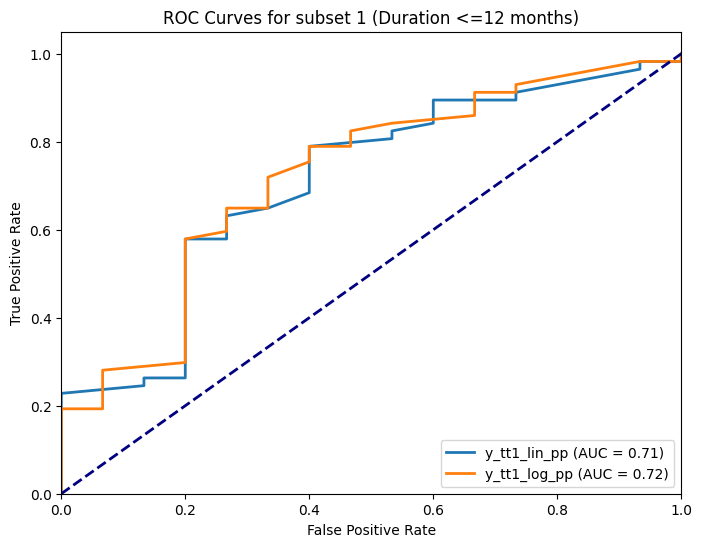

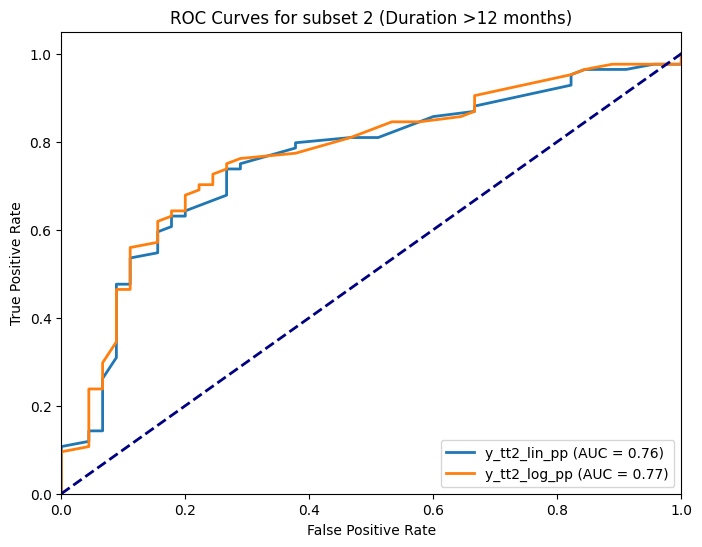

In [82]:
# ROC curves

# Define models and test sets
models_test1 = {
    'y_tt1_lin_pp': y_tt1_lin_pp,
    'y_tt1_log_pp': y_tt1_log_pp
}

models_test2 = {
    'y_tt2_lin_pp': y_tt2_lin_pp,
    'y_tt2_log_pp': y_tt2_log_pp
}

# Plot ROC curves for y_test1
plt.figure(figsize=(8, 6))
for model_name, y_pred in models_test1.items():
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test1, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for subset 1 (Duration <=12 months)')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curves for y_test2
plt.figure(figsize=(8, 6))
for model_name, y_pred in models_test2.items():
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test2, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for subset 2 (Duration >12 months)')
plt.legend(loc="lower right")
plt.show()

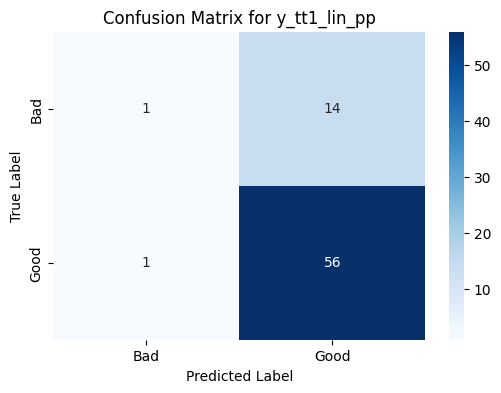

Specificity (True Negative Rate) for y_tt1_lin_pp: 0.07
Sensitivity (True Positive Rate/Recall) for y_tt1_lin_pp: 0.98



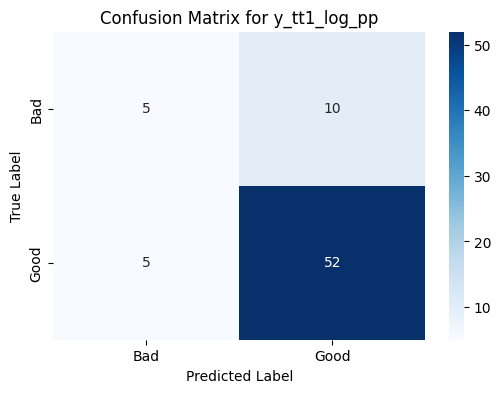

Specificity (True Negative Rate) for y_tt1_log_pp: 0.33
Sensitivity (True Positive Rate/Recall) for y_tt1_log_pp: 0.91



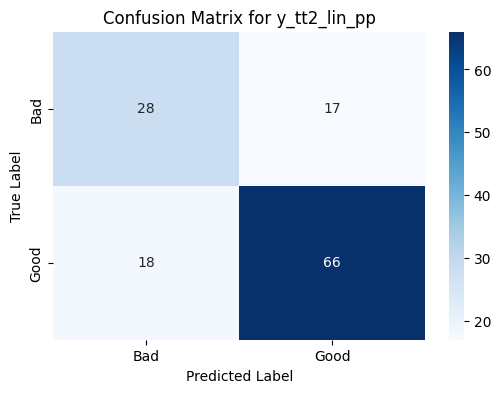

Specificity (True Negative Rate) for y_tt2_lin_pp: 0.62
Sensitivity (True Positive Rate/Recall) for y_tt2_lin_pp: 0.79



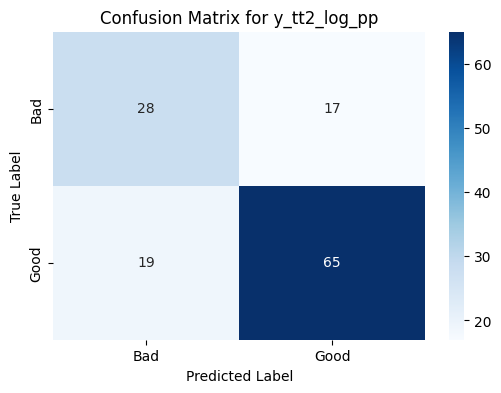

Specificity (True Negative Rate) for y_tt2_log_pp: 0.62
Sensitivity (True Positive Rate/Recall) for y_tt2_log_pp: 0.77



In [83]:
# Specificity and Sensitivity

# Specificity = TN/(TN/FP) = True Negative Rate
# Sensitivity = TP/(TP/FN) = True Positive Rate = Recall

# Define model predictions and test sets
predictions = {
    'y_tt1_lin_pp': y_tt1_lin_pp,
    'y_tt1_log_pp': y_tt1_log_pp,
    'y_tt2_lin_pp': y_tt2_lin_pp,
    'y_tt2_log_pp': y_tt2_log_pp
}

test_sets = {
    'y_tt1_lin_pp': y_test1,
    'y_tt1_log_pp': y_test1,
    'y_tt2_lin_pp': y_test2,
    'y_tt2_log_pp': y_test2
}

# Loop through predictions
for name, y_pred in predictions.items():
    # Generate class predictions with 0.5 threshold
    y_class = (y_pred > 0.5).astype(int)

    # Get the corresponding test set
    y_test = test_sets[name]

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_class)
    tn, fp, fn, tp = conf_matrix.ravel()

    # Calculate Specificity and Sensitivity
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    # Print results
    print(f"Specificity (True Negative Rate) for {name}: {specificity:.2f}")
    print(f"Sensitivity (True Positive Rate/Recall) for {name}: {sensitivity:.2f}\n")

In [84]:
# Gini coefficient

# G = 2AUROC-1

# Calculate AUROC for each model
# Subset 1 - linear
fpr_lin1, tpr_lin1, thresholds_lin1 = roc_curve(y_test1, y_tt1_lin_pp)
roc_auc_lin1 = auc(fpr_lin1, tpr_lin1)
# Subset 1 - logistic
fpr_log1, tpr_log1, thresholds_log1 = roc_curve(y_test1, y_tt1_log_pp)
roc_auc_log1 = auc(fpr_log1, tpr_log1)

# Subset 2 - linear
fpr_lin2, tpr_lin2, thresholds_lin2 = roc_curve(y_test2, y_tt2_lin_pp)
roc_auc_lin2 = auc(fpr_lin2, tpr_lin2)
# Subset 2 - logistic
fpr_log2, tpr_log2, thresholds_log2 = roc_curve(y_test2, y_tt2_log_pp)
roc_auc_log2 = auc(fpr_log2, tpr_log2)

# Calculate Gini Coefficients for each model
gini_lin1 = 2 * roc_auc_lin1 - 1
gini_log1 = 2 * roc_auc_log1 - 1

gini_lin2 = 2 * roc_auc_lin2 - 1
gini_log2 = 2 * roc_auc_log2 - 1


# Print Gini Coefficients for each model
print(f"Gini coefficient for subset 1 linear regression: {gini_lin1:.2f}")
print(f"Gini coefficient for subset 1 logistic regression: {gini_log1:.2f}\n")
print(f"Gini coefficient for subset 2 linear regression: {gini_lin2:.2f}")
print(f"Gini coefficient for subset 2 logistic regression: {gini_log2:.2f}\n")

Gini coefficient for subset 1 linear regression: 0.42
Gini coefficient for subset 1 logistic regression: 0.44

Gini coefficient for subset 2 linear regression: 0.51
Gini coefficient for subset 2 logistic regression: 0.54



In [85]:
# Kolmogorov-Smirnov Value

# maximum absolute difference in F(s|B) and F(s|G)

# Calculate scores for each sample in the test set

# Subset 1 (<=12 months) - LinearRegression
# calculate score
xtt_1['P1_lin1'] = y_tt1_lin_pp
xtt_1['P0_lin1'] = 1-y_tt1_lin_pp
xtt_1['Score_lin'] = np.ceil(np.log(xtt_1['P1_lin1']/xtt_1['P0_lin1']) * factor + offset)
xtt_1
#print(xtt_1['Score_lin'].describe())

# Subset 1 (<=12 months) - Logistic Regression
# calculate score
xtt_1['P1_log1'] = y_tt1_log_pp
xtt_1['P0_log1'] = 1-y_tt1_log_pp
xtt_1['Score_log'] = np.ceil(np.log(xtt_1['P1_log1']/xtt_1['P0_log1']) * factor + offset)
xtt_1
#print(xtt_1['Score_log'].describe())


# Subset 2 (>12 months) - LinearRegression
# calculate score
xtt_2['P1_lin2'] = y_tt2_lin_pp
xtt_2['P0_lin2'] = 1-y_tt2_lin_pp
xtt_2['Score_lin'] = np.ceil(np.log(xtt_2['P1_lin2']/xtt_2['P0_lin2']) * factor + offset)
xtt_2
#print(xtt_2['Score_lin'].describe())

# Subset 2 (>12 months) - Logistic Regression
# calculate score
xtt_2['P1_log2'] = y_tt2_log_pp
xtt_2['P0_log2'] = 1-y_tt2_log_pp
xtt_2['Score_log'] = np.ceil(np.log(xtt_2['P1_log2']/xtt_2['P0_log2']) * factor + offset)
xtt_2
#print(xtt_2['Score_log'].describe())

,const,qChecking_2,qChecking_3,qChecking_4,qEmployed_2+3,qEmployed_4+5,qSavings_2,qSavings_3+4+5,nDuration_24-35,nDuration_36-47,nDuration_48+,P1_lin2,P0_lin2,Score_lin,P1_log2,P0_log2,Score_log
988,1.0,0,0,0,0,0,0,0,1,0,0,0.318487,0.681513,466.0,0.298874,0.701126,463.0
655,1.0,0,0,0,0,0,0,0,0,0,0,0.359103,0.640897,471.0,0.346703,0.653297,469.0
347,1.0,1,0,0,0,0,0,1,1,0,0,0.577840,0.422160,497.0,0.615197,0.384803,501.0
717,1.0,0,0,1,1,0,0,0,0,0,0,0.803074,0.196926,528.0,0.827143,0.172857,533.0
310,1.0,1,0,0,0,0,0,1,0,0,1,0.371173,0.628827,472.0,0.358332,0.641668,471.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,1.0,1,0,0,1,0,0,0,1,0,0,0.510889,0.489111,489.0,0.488309,0.511691,486.0
181,1.0,1,0,0,1,0,0,0,0,1,0,0.408836,0.591164,477.0,0.362986,0.637014,471.0
926,1.0,0,0,0,1,0,0,0,0,0,0,0.414977,0.585023,478.0,0.395970,0.604030,475.0
712,1.0,0,0,1,0,1,0,1,0,0,0,0.999999,0.000001,886.0,0.950738,0.049262,573.0


In [86]:
# df for Kolmogorov-Smirnov Value for Subset 1 (<=12 months) - LinearRegression
ks_lin1 = pd.DataFrame({
    'Score': xtt_1['Score_lin'],
    'Actual': y_test1
}).sort_values(by='Score', ascending=True)

# cumulative FN
ks_lin1['FN'] = ks_lin1['Actual'].cumsum()

# cumulative TN
ks_lin1['TN'] = ks_lin1['Actual'].eq(0).cumsum()

# Add cumulative FP
ks_lin1['FP'] = ks_lin1['TN'].iloc[-1] - ks_lin1['TN']

# Add cumulative TP
ks_lin1['TP'] = ks_lin1['FN'].iloc[-1] - ks_lin1['FN']

# F(s|G)
ks_lin1['F(s|G)'] = ks_lin1['FN'] / ks_lin1['FN'].iloc[-1]

# F(s|B)
ks_lin1['F(s|B)'] = ks_lin1['TN'] / ks_lin1['TN'].iloc[-1]

# Kolmogorov-Smirnov Value
ks_lin1['KS_Stat'] = abs(ks_lin1['F(s|G)'] - ks_lin1['F(s|B)'])

print(ks_lin1['KS_Stat'].max())
# ks_lin1

0.3894736842105263


In [87]:
# df for Kolmogorov-Smirnov Value for Subset 1 (<=12 months) - LogisticRegression
ks_log1 = pd.DataFrame({
    'Score': xtt_1['Score_log'],
    'Actual': y_test1
}).sort_values(by='Score', ascending=True)

# cumulative FN
ks_log1['FN'] = ks_log1['Actual'].cumsum()

# cumulative TN
ks_log1['TN'] = ks_log1['Actual'].eq(0).cumsum()

# Add cumulative FP
ks_log1['FP'] = ks_log1['TN'].iloc[-1] - ks_log1['TN']

# Add cumulative TP
ks_log1['TP'] = ks_log1['FN'].iloc[-1] - ks_log1['FN']

# F(s|G)
ks_log1['F(s|G)'] = ks_log1['FN'] / ks_log1['FN'].iloc[-1]

# F(s|B)
ks_log1['F(s|B)'] = ks_log1['TN'] / ks_log1['TN'].iloc[-1]

# Kolmogorov-Smirnov Value
ks_log1['KS_Stat'] = abs(ks_log1['F(s|G)'] - ks_log1['F(s|B)'])

print(ks_log1['KS_Stat'].max())
# ks_log1

0.40350877192982454


In [88]:
# df for Kolmogorov-Smirnov Value for Subset 2 (>12 months) - LinearRegression
ks_lin2 = pd.DataFrame({
    'Score': xtt_2['Score_lin'],
    'Actual': y_test2
}).sort_values(by='Score', ascending=True)

# cumulative FN
ks_lin2['FN'] = ks_lin2['Actual'].cumsum()

# cumulative TN
ks_lin2['TN'] = ks_lin2['Actual'].eq(0).cumsum()

# Add cumulative FP
ks_lin2['FP'] = ks_lin2['TN'].iloc[-1] - ks_lin2['TN']

# Add cumulative TP
ks_lin2['TP'] = ks_lin2['FN'].iloc[-1] - ks_lin2['FN']

# F(s|G)
ks_lin2['F(s|G)'] = ks_lin2['FN'] / ks_lin2['FN'].iloc[-1]

# F(s|B)
ks_lin2['F(s|B)'] = ks_lin2['TN'] / ks_lin2['TN'].iloc[-1]

# Kolmogorov-Smirnov Value
ks_lin2['KS_Stat'] = abs(ks_lin2['F(s|G)'] - ks_lin2['F(s|B)'])

print(ks_lin2['KS_Stat'].max())
# ks_lin2

0.4833333333333333


In [89]:
# Create DataFrame for Score_log - xtt_2
ks_log2 = pd.DataFrame({
    'Score': xtt_2['Score_log'],
    'Actual': y_test2
}).sort_values(by='Score', ascending=True)

# cumulative FN
ks_log2['FN'] = ks_log2['Actual'].cumsum()

# cumulative TN
ks_log2['TN'] = ks_log2['Actual'].eq(0).cumsum()

# Add cumulative FP
ks_log2['FP'] = ks_log2['TN'].iloc[-1] - ks_log2['TN']

# Add cumulative TP
ks_log2['TP'] = ks_log2['FN'].iloc[-1] - ks_log2['FN']

# F(s|G)
ks_log2['F(s|G)'] = ks_log2['FN'] / ks_log2['FN'].iloc[-1]

# F(s|B)
ks_log2['F(s|B)'] = ks_log2['TN'] / ks_log2['TN'].iloc[-1]

# Kolmogorov-Smirnov Value
ks_log2['KS_Stat'] = abs(ks_log2['F(s|G)'] - ks_log2['F(s|B)'])

print(ks_log2['KS_Stat'].max())
# ks_log2

0.484920634920635


In [90]:
# Print KS results for each model

print(f"Kolmogrov-Smirnov statistic for subset 1 linear regression: {ks_lin1['KS_Stat'].max():.3f}")
print(f"Kolmogrov-Smirnov statistic for subset 1 logistic regression: {ks_log1['KS_Stat'].max():.3f}\n")
print(f"Kolmogrov-Smirnov statistic for subset 2 linear regression: {ks_lin2['KS_Stat'].max():.3f}")
print(f"Kolmogrov-Smirnov statistic for subset 2 logistic regression: {ks_log2['KS_Stat'].max():.3f}\n")

Kolmogrov-Smirnov statistic for subset 1 linear regression: 0.389
Kolmogrov-Smirnov statistic for subset 1 logistic regression: 0.404

Kolmogrov-Smirnov statistic for subset 2 linear regression: 0.483
Kolmogrov-Smirnov statistic for subset 2 logistic regression: 0.485



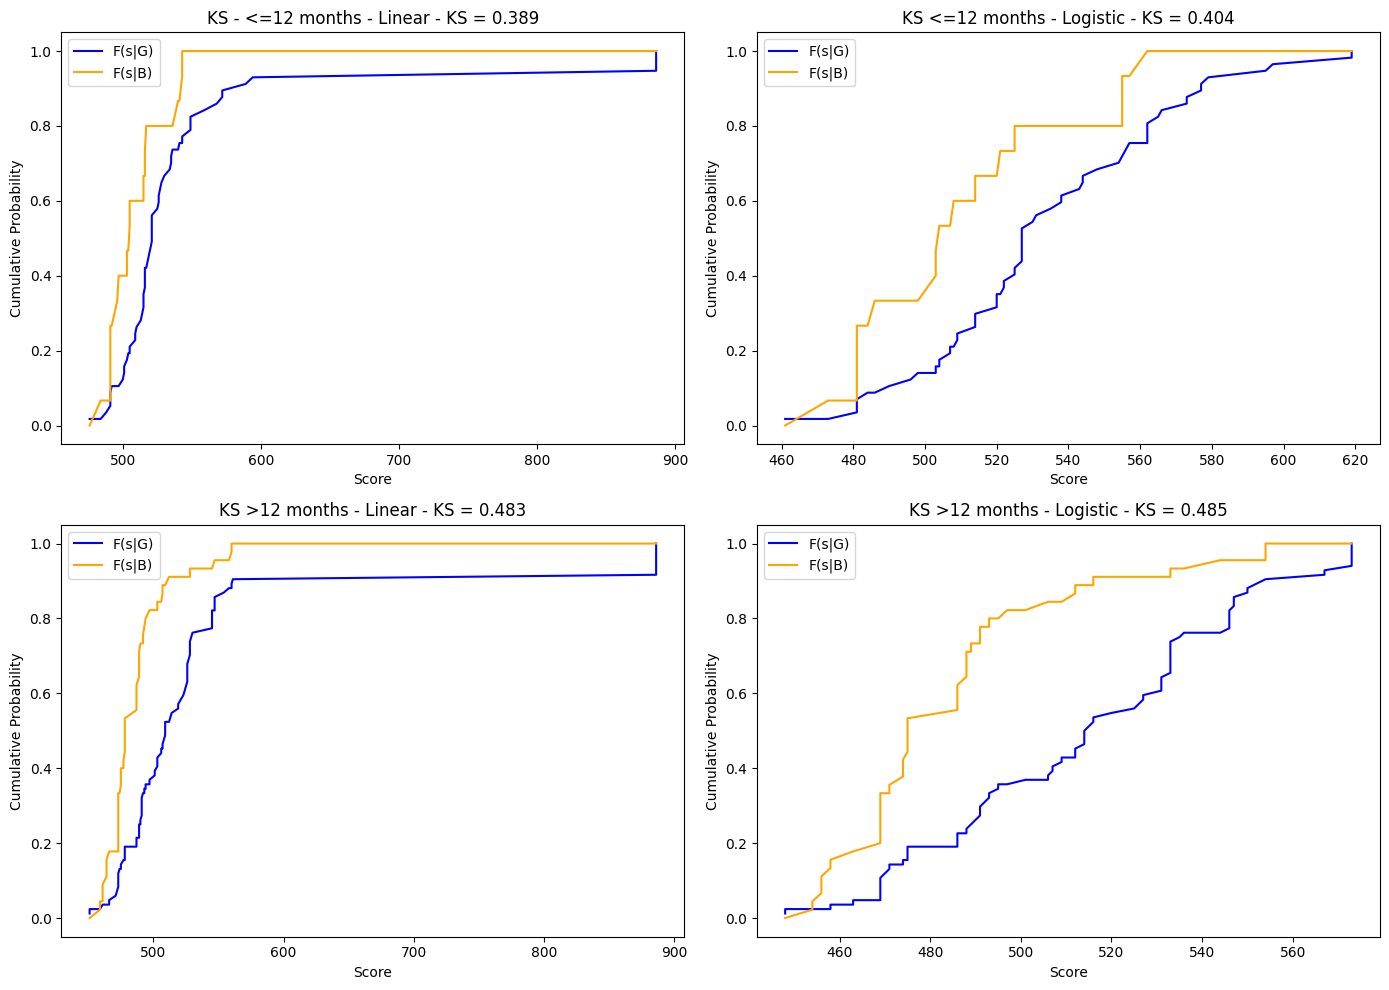

In [91]:
# Plot KS curves for each model

# List of ks_ dataframes and their corresponding titles
ks_dfs = [ks_lin1, ks_log1, ks_lin2, ks_log2,]
titles = ['KS - <=12 months - Linear', 'KS <=12 months - Logistic', 'KS >12 months - Linear', 'KS >12 months - Logistic']

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Loop over the ks_dfs and plot
for i, (ks_df, title) in enumerate(zip(ks_dfs, titles)):
    row = i // 2
    col = i % 2

    # Plot the F(s|G) and F(s|B) curves against score
    axs[row, col].plot(ks_df['Score'], ks_df['F(s|G)'], label='F(s|G)', color='blue')
    axs[row, col].plot(ks_df['Score'], ks_df['F(s|B)'], label='F(s|B)', color='orange')

    # Set labels and title
    axs[row, col].set_xlabel('Score')
    axs[row, col].set_ylabel('Cumulative Probability')
    axs[row, col].set_title(f'{title} - KS = {ks_df["KS_Stat"].max():.3f}')
    axs[row, col].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()